In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Carregar o arquivo Excel
xls = pd.ExcelFile('Exercicio_Python_CRM .xlsx')

# Obter os nomes das abas
sheet_names = xls.sheet_names

# Para cada aba, ler o schema e as primeiras 10 linhas
for sheet in sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet, nrows=10)
    # print(f"Schema para {sheet}:")
    # print(df.dtypes)
    # print(f"Primeiras 10 linhas para {sheet}:")
    # print(df.head(10))


import openpyxl

# arquivo
wb = openpyxl.load_workbook('Exercicio_Python_CRM .xlsx', read_only=True)

# aba de transações
ws = wb['Transações']

# tamanho do chunk para leitura de bases grandes
chunk_size = 100000
chunks = []

# cabeçalho (nomes das colunas) da primeira linha
header = [cell.value for cell in ws[1]]

# dados em chunks para bases com milhões de linhas
for i in range(2, ws.max_row, chunk_size):  # Comecça de 2 porque a primeira linha é o cabeçalho
    rows = ws[i:i + chunk_size]
    data = [[cell.value for cell in row] for row in rows]
    df = pd.DataFrame(data, columns=header)  # Usando o cabeçalho como nomes das colunas
    chunks.append(df)

# Concatenando os chunks em um único DataFrame
df_t = pd.concat(chunks, axis=0)

# Para cada coluna no DataFrame
for col in df_t.columns:
    # Se o tipo de dados da coluna é object (string)
    if df_t[col].dtype == 'object':
        # Remova os espaços em branco no início e no final
        df_t[col] = df_t[col].str.strip()

df_t['Promo'] = df_t['Promo'].astype(str)
cols = [col for col in df_t.columns if 'ID' not in col]
null_counts = df_t.isnull().sum()

##### Primeira parte da análise:
- análise descritiva da base de Transações
- agregação Ano e Mês
- KPI Ticket Médio
###### nesta primeira parte da análise é possível verificar que:
- a base apenas possui dados para 01-2022 até 09-2022 e depois 01-2023 até 09-2023 faltando o último trimestre dos dois anos; época de Natal!
- as vendas de 2023 apenas se recuperaram no terceiro trimestre
- o ano de 2023 teve menos promoções e menos Unidades vendidas em relação a 2022, porém obteve um Valor Total maior indicando que houve um Ticket Médio maior em 2023 em relação a 2022
- o Ticket Médio de 2023 foi sempre maior que 2022 no agregado mês a mês
 

In [2]:
import plotly.graph_objects as go
import seaborn as sns

# Data to datetime
df_t['Data'] = pd.to_datetime(df_t['Data'])

# Criando colunas para o mês e o ano
df_t['Year'] = df_t['Data'].dt.year
df_t['Month'] = df_t['Data'].dt.month

# Agrupando os dados por ano e mês
grouped = df_t.groupby(['Year', 'Month']).sum().reset_index()

# Obtendo as cores da paleta "Pastel2"
colors = sns.color_palette("Pastel2", len(grouped['Year'].unique())).as_hex()

# Criando o gráfico de barras para 'ValorTotal'
fig = go.Figure()

for i, year in enumerate(grouped['Year'].unique()):
    fig.add_trace(go.Bar(x=grouped[grouped['Year'] == year]['Month'], 
                         y=grouped[grouped['Year'] == year]['ValorTotal'], 
                         name=str(year),
                         marker_color=colors[i]))  # Aplicando as cores

# Configurando os eixos e adicionando título
fig.update_layout(
    title={
        'text': 'Valor Total por Mês e Ano',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis=dict(title='Month'),
    yaxis=dict(title='ValorTotal'),
)

fig.show()

In [3]:
# Definindo a paleta de cores Pastel2
pastel2 = ['#b3e2cd', '#fdcdac', '#cbd5e8', '#f4cae4', '#e6f5c9', '#fff2ae', '#f1e2cc', '#cccccc']

# Criando colunas para o mês e o ano
df_t['Year'] = df_t['Data'].dt.year
df_t['Month'] = df_t['Data'].dt.month

# Agrupando os dados por ano e mês
grouped = df_t.groupby(['Year', 'Month']).sum().reset_index()

# Criando a figura
fig = go.Figure()

# Adicionando o gráfico de barras para 'ValorTotal'
for i, year in enumerate(grouped['Year'].unique()):
    fig.add_trace(go.Bar(x=grouped[grouped['Year'] == year]['Month'], 
                         y=grouped[grouped['Year'] == year]['ValorTotal'], 
                         name='ValorTotal ' + str(year),
                         marker_color=pastel2[i % len(pastel2)]))  # Use a cor correspondente da paleta

# Adicionando o gráfico de linha para 'UnidadesVendidas'
for i, year in enumerate(grouped['Year'].unique()):
    line_color = '#ff0000' if year == 2023 else pastel2[(i + len(pastel2) // 2) % len(pastel2)]  # Use a cor vermelha para 2023
    fig.add_trace(go.Scatter(x=grouped[grouped['Year'] == year]['Month'], 
                             y=grouped[grouped['Year'] == year]['UnidadesVendidas'], 
                             name='UnidadesVendidas ' + str(year), 
                             yaxis='y2',
                             line_color=line_color))

# Configurando os eixos e a legenda
fig.update_layout(
    title={
        'text': "Unidades Vendidas e Valor Total por Mês e Ano",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, 
    xaxis=dict(title='Month'),
    yaxis=dict(title='ValorTotal'),
    yaxis2=dict(title='UnidadesVendidas', overlaying='y', side='right'),
    autosize=False,
    width=900,  
    legend=dict(
        x=1.1,  
        y=1,  # Posiciona a legenda no topo
        bgcolor='rgba(255, 255, 255, 0)',  # Fundo transparente para a legenda
        bordercolor='rgba(255, 255, 255, 0)'  # Borda transparente para a legenda
    )
)

fig.show()

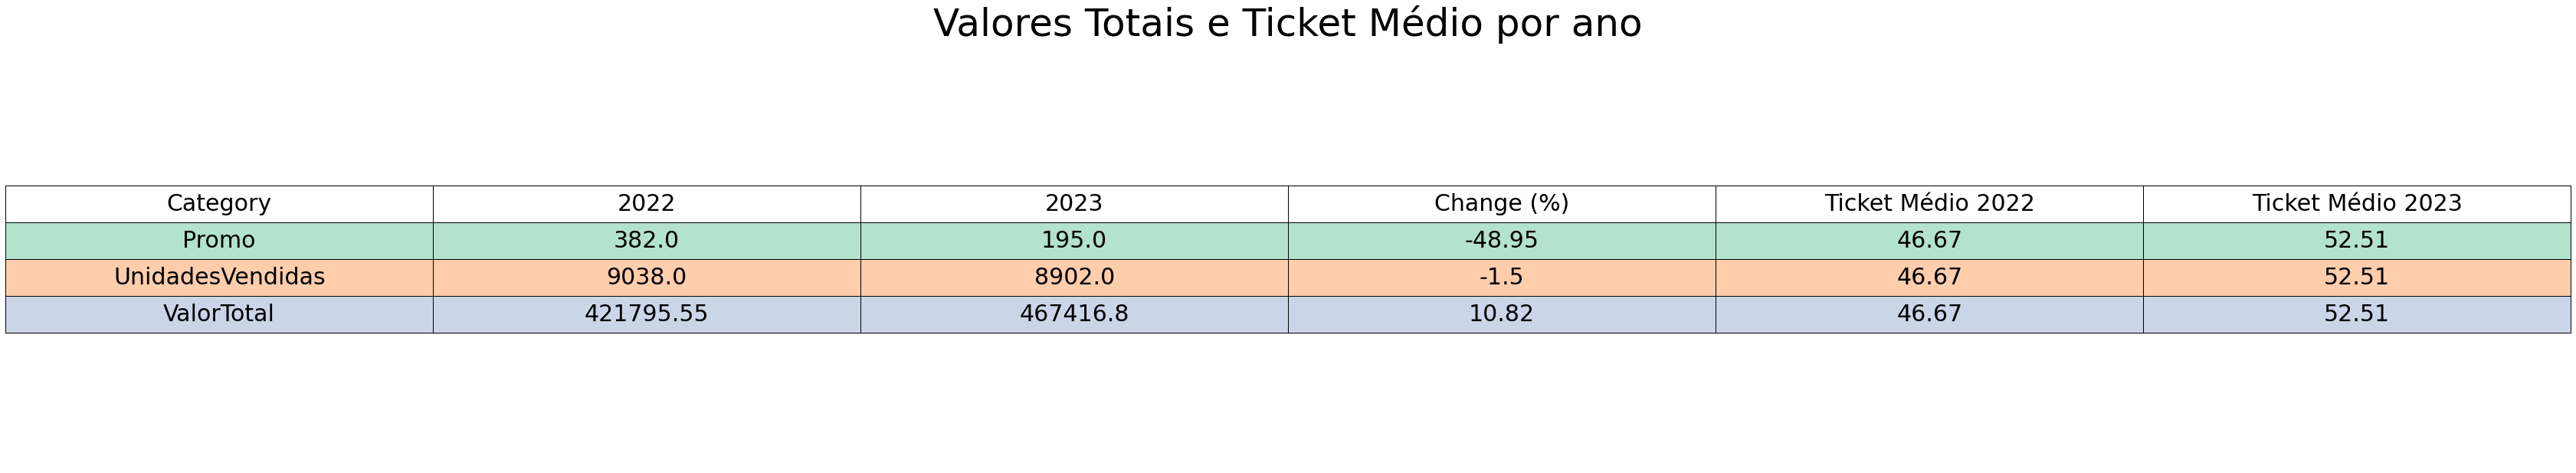

In [4]:
# Preenchendo os valores nulos na coluna 'Promo' com 0
df_t['Promo'] = df_t['Promo'].fillna(0)

# Convertendo a coluna 'Promo' para float, substituindo NaNs por 0 e depois convertendo para inteiro
df_t['Promo'] = np.nan_to_num(df_t['Promo'].astype(float)).astype(int)

# Filtrando os dados para os anos de 2022 e 2023
df_t['Year'] = df_t['Data'].dt.year
df_t['Month'] = df_t['Data'].dt.month
df_filtered = df_t[df_t['Year'].isin([2022, 2023])]

# Criando a tabela agregada
pivot = df_filtered.pivot_table(index='Month', columns='Year', values=['ValorTotal', 'UnidadesVendidas', 'Promo'], aggfunc='sum')

# Adicionando a linha com o valor total
pivot.loc['Total'] = pivot.sum()

# Extraindo a linha 'Total'
total_values = pivot.loc['Total']

# Transpondo a série para um DataFrame e resetando o índice
total_df = total_values.transpose().reset_index()

# Renomeando as colunas
total_df.columns = ['Category', 'Year', 'Value']

# Pivotando o DataFrame
pivot_total = total_df.pivot(index='Category', columns='Year', values='Value')

# Calculando a mudança percentual
pivot_total['Change (%)'] = (pivot_total[2023] - pivot_total[2022]) / pivot_total[2022] * 100

pivot_total['Ticket Médio 2022'] = pivot_total[2022]['ValorTotal'] / pivot_total[2022]['UnidadesVendidas']
pivot_total['Ticket Médio 2023'] = pivot_total[2023]['ValorTotal'] / pivot_total[2023]['UnidadesVendidas']

import matplotlib.pyplot as plt

# Definindo o tamanho da figura
fig, ax = plt.subplots(figsize=(15, 10))

# Add a title to the plot
ax.set_title('Valores Totais e Ticket Médio por ano', fontsize=50, pad=20)

# Rest of your code...
# Adicionando a tabela à figura
table_data = pivot_total.reset_index().round(2).values.tolist()
column_labels = pivot_total.reset_index().columns.tolist()

# Definindo as cores
colors = sns.color_palette("Pastel2").as_hex()

# Criando uma matriz de cores
cell_colors = [[colors[i%len(colors)] for _ in row] for i, row in enumerate(table_data)]

# Adicionando a tabela à figura
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc = 'center', loc='center', cellColours=cell_colors)

# Ajustando o tamanho da fonte
table.auto_set_font_size(False)
table.set_fontsize(30)  # Increase this value to increase the font size

# Aumentando a largura e altura geral da tabela
table.scale(4, 4)  # Increase the second value to increase the height of the rows

# Ajustando o tamanho da fonte dos cabeçalhos
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_fontsize(30)  # Increase this value to increase the font size of the headers

# Ajustando o tamanho da fonte da coluna 'DescProduto'
for key, cell in table.get_celld().items():
    if key[1] == 0:  # 0 é o índice da coluna 'DescProduto'
        cell.set_fontsize(30)  # Increase this value to increase the font size of the 'DescProduto' column
# Escondendo os eixos
ax.axis('off')

# Salvando a figura como .png
plt.savefig('pivot_total_table.png')


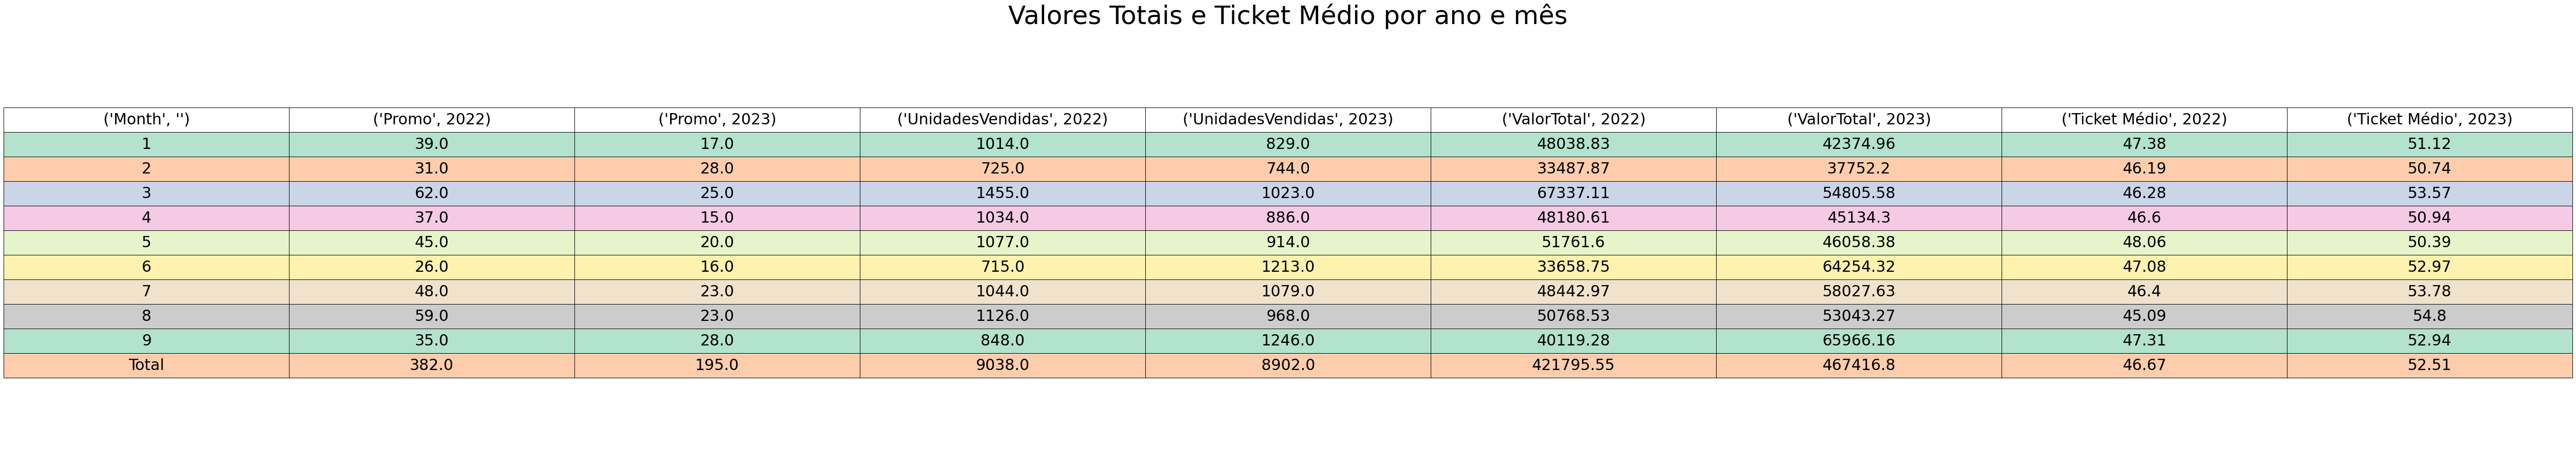

In [5]:
# 'Ticket Médio' para 2022 and 2023
pivot[('Ticket Médio', 2022)] = pivot[('ValorTotal', 2022)] / pivot[('UnidadesVendidas', 2022)]
pivot[('Ticket Médio', 2023)] = pivot[('ValorTotal', 2023)] / pivot[('UnidadesVendidas', 2023)]


# Definindo o tamanho da figura
fig, ax = plt.subplots(figsize=(20, 15))  # Aumentando a largura da figura

# Add a title to the plot
ax.set_title('Valores Totais e Ticket Médio por ano e mês', fontsize=50, pad=20)

# Adicionando a tabela à figura
table_data = pivot.reset_index().round(2).values.tolist()  # Arredondando os valores para 2 casas decimais
column_labels = pivot.reset_index().columns.tolist()

# Definindo as cores
colors = sns.color_palette("Pastel2").as_hex()

# Criando uma matriz de cores
cell_colors = [[colors[i%len(colors)] for _ in row] for i, row in enumerate(table_data)]

# Adicionando a tabela à figura
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc = 'center', loc='center', cellColours=cell_colors)

# Ajustando o tamanho da fonte
table.auto_set_font_size(False)
table.set_fontsize(30)

# Ajustando o tamanho da fonte dos cabeçalhos
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_fontsize(30)

# Ajustando a largura das colunas e a altura das linhas
table.scale(4.5, 4)  # Aumentando a largura das colunas e a altura das linhas

# Escondendo os eixos
ax.axis('off')

# Salvando a figura como .png
plt.savefig('pivot_table_with_ticket_medio.png')

In [6]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define a list of colors
colors = ['#b3e2cd', '#fdcdac', '#cbd5e8', '#f4cae4', '#e6f5c9', '#fff2ae', '#f1e2cc', '#cccccc']

# Calcular o Ticket Médio
df_t['Ticket Médio'] = df_t['ValorTotal'] / df_t['UnidadesVendidas']

# Agrupar os dados e calcular a média
df_grouped = df_t.groupby(['Year', 'Month']).agg({'UnidadesVendidas': 'sum', 'ValorTotal': 'sum', 'Promo': 'sum', 'Ticket Médio': 'mean'}).reset_index()

# Obter o número de colunas
num_cols = len(df_grouped.columns) - 2  # Subtrair as colunas 'Year' e 'Month'

# Calcular o número de linhas e colunas para os subplots
num_rows = num_cols // 2 if num_cols % 2 == 0 else num_cols // 2 + 1

# Criar subplots
fig = make_subplots(rows=num_rows, cols=2, subplot_titles=df_grouped.columns[2:])

# Adicionar traços
for i, header in enumerate(df_grouped.columns[2:]):
    row = i // 2 + 1
    col = i % 2 + 1
    for j, year in enumerate(df_grouped['Year'].unique()):
        df_year = df_grouped[df_grouped['Year'] == year]
        fig.add_trace(go.Scatter(x=df_year['Month'], y=df_year[header], mode='lines', name=f'{header} {year}', line=dict(color=colors[j % len(colors)])), row=row, col=col)

# Atualizar layout
fig.update_layout(height=600, width=800, title_text="Subplots")
fig.show()

#### Segunda parte da análise:
- explorando os dados de transações com as Marcas e suas categorias

##### nesta segunda parte da análise é possível verificar que:

###### O top vermelho gammaz - teve ótimo desempenho,
###### - ficou em segundo lugar no rank de Ticket Médio (TM) no ano de 2023. Caiu 1 posição em relação a 2022
###### - se manteve em primeiro em relação a Unidades Vendidas e Valor Total (VT) 2022 e 2023
###### - fez menos promoções em 2023 em relação a 2022 - caiu de sexto em quantidade de promoções para sétimo
###### mas o Botton azul Gammaz também teve destaque!

###### 2023	Bottom Azul Marca GammaZ  ->	TM - 88.517723	 VT - 75759.52
###### 2023	Top Vermelho Marca GammaZ ->	TM - 83.774699	 VT - 146329.22

###### O Botton azul gammaz que não foi vendido em 2022 teve um desempenho melhor em 2023 quando se olha pra Ticket Médio.

###### A Marca Gammaz no geral teve um bom desempenho pra Ticket Médio e Valor Total, ultrapassando em Valor Total a Marca AlfaX
 
###### As promoções não impulsionaram o negócio de forma geral

###### Cores vermelhas são representativas em vendas, mas um destaque foram peças azuis, que melhoraram tanto em quantidade vendida, quanto em aumento de ticket médio e valor Total

###### Houve crescimento de Ticket médio de peças tipo Botton e também Valor Total, o que ajuda a explicar o sucesso do Botton azul gammaz


In [7]:
import openpyxl
import pandas as pd

# arquivo
wb = openpyxl.load_workbook('Exercicio_Python_CRM .xlsx', read_only=True)

# aba de produto
ws = wb['Produto']

# tamanho do chunk para leitura de bases grandes
chunk_size = 100000
chunks = []

# cabeçalho (nomes das colunas) da primeira linha
header = [cell.value for cell in ws[1]]

# dados em chunks para bases com milhões de linhas
for i in range(2, ws.max_row, chunk_size):  # Comecça de 2 porque a primeira linha é o cabeçalho
    rows = ws[i:i + chunk_size]
    data = [[cell.value for cell in row] for row in rows]
    df = pd.DataFrame(data, columns=header)  # Usando o cabeçalho como nomes das colunas
    chunks.append(df)

# Concatenando os chunks em um único DataFrame
df_p = pd.concat(chunks, axis=0)

# Para cada coluna no DataFrame
for col in df_p.columns:
    # Se o tipo de dados da coluna é object (string)
    if df_p[col].dtype == 'object':
        # Remova os espaços em branco no início e no final  
        df_p[col] = df_p[col].str.strip()


# Ajuste da coluna 'Descrição Produto'
def update_description(row):
    if row['Categoria'] not in row['Descrição Produto']:
        row['Descrição Produto'] = row['Categoria'] + ' ' + row['Descrição Produto']
    if row['Cor'] not in row['Descrição Produto']:
        row['Descrição Produto'] = row['Descrição Produto'].replace(row['Categoria'], row['Categoria'] + ' ' + row['Cor'])
    if 'Marca' not in row['Descrição Produto'] and row['Marca'] not in row['Descrição Produto']:
        row['Descrição Produto'] = row['Descrição Produto'].replace(row['Marca'], 'Marca ' + row['Marca'])
    return row

df_p = df_p.apply(update_description, axis=1)

df_p.loc[df_p['ID_Produto'] == 123010, 'Descrição Produto'] = 'Bottom Azul Marca GammaZ'
df_p.loc[df_p['ID_Produto'] == 123011, 'Descrição Produto'] = 'Bottom Azul Marca BetaY'

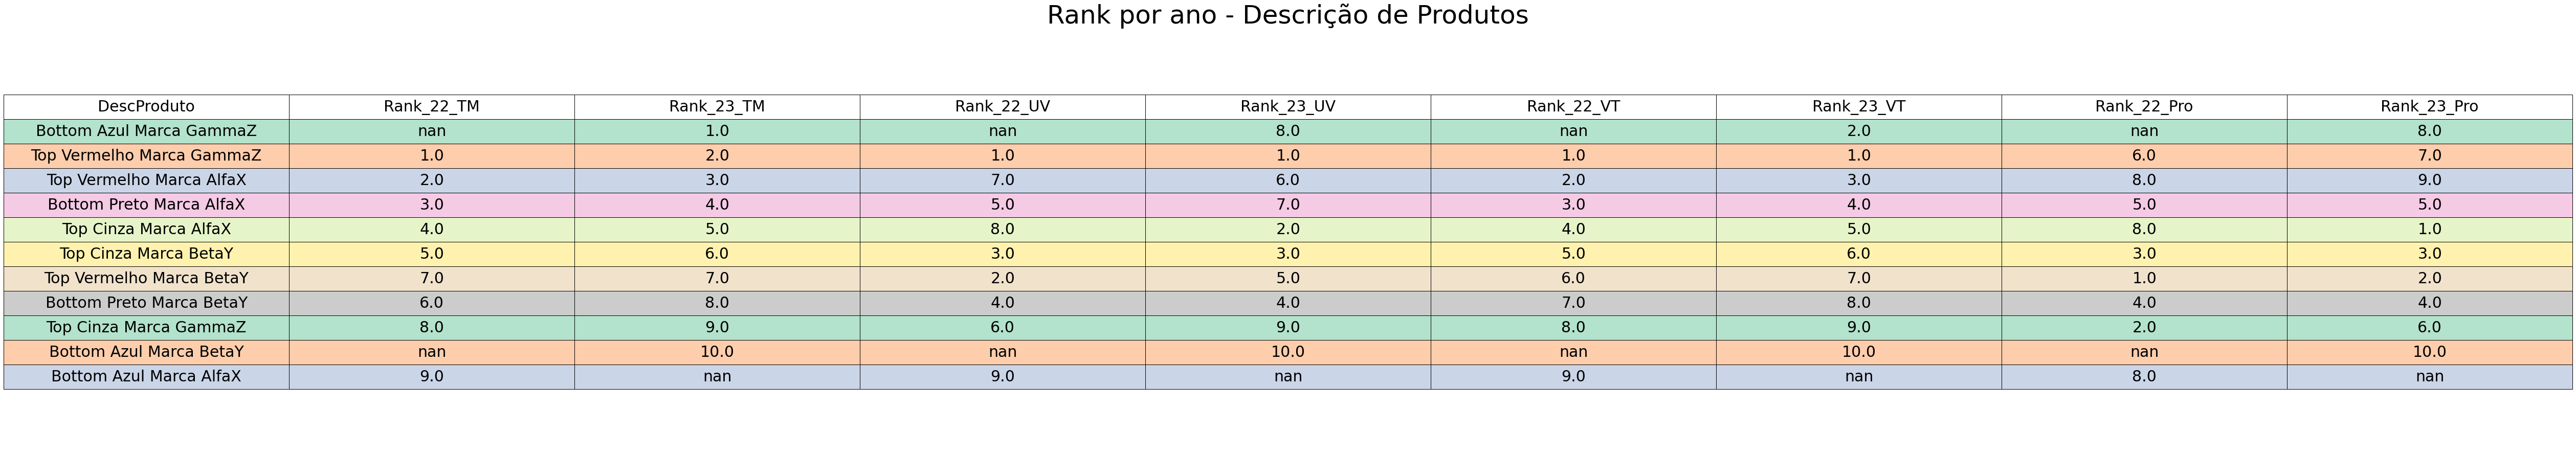

In [8]:
# Ajuste da coluna 'Descrição Produto'
def update_description(row):
    if row['Categoria'] not in row['Descrição Produto']:
        row['Descrição Produto'] = row['Categoria'] + ' ' + row['Descrição Produto']
    if row['Cor'] not in row['Descrição Produto']:
        row['Descrição Produto'] = row['Descrição Produto'].replace(row['Categoria'], row['Categoria'] + ' ' + row['Cor'])
    if 'Marca' not in row['Descrição Produto'] and row['Marca'] not in row['Descrição Produto']:
        row['Descrição Produto'] = row['Descrição Produto'].replace(row['Marca'], 'Marca ' + row['Marca'])
    return row

df_p = df_p.apply(update_description, axis=1)
df_p.loc[df_p['ID_Produto'] == 123010, 'Descrição Produto'] = 'Bottom Azul Marca GammaZ'
df_p.loc[df_p['ID_Produto'] == 123011, 'Descrição Produto'] = 'Bottom Azul Marca BetaY'
df_tp = pd.merge(df_t, df_p, on='ID_Produto', how='left')
del df_t
df_tp_drp = df_tp.drop(columns=['ID_Trans', 'Data', 'ID_Loja', 'ID_Produto', 'ID_Cliente', 'Month'])
grouped_df = df_tp_drp.groupby(['Descrição Produto', 'Categoria', 'Cor', 'Marca', 'Year']).agg({'Ticket Médio': 'mean', 'UnidadesVendidas': 'sum', 'ValorTotal': 'sum', 'Promo': 'sum'}).reset_index()

# Filtrar o DataFrame por ano e criar dois DataFrames separados
df1 = grouped_df[grouped_df['Year'] == 2022].copy()
df2 = grouped_df[grouped_df['Year'] == 2023].copy()

# Criar uma classificação de "UnidadesVendidas" em cada DataFrame
df1['Rank_2022_UnidadesVendidas'] = df1['UnidadesVendidas'].rank(ascending=False)
df2['Rank_2023_UnidadesVendidas'] = df2['UnidadesVendidas'].rank(ascending=False)

# Mesclar os dois DataFrames usando uma junção externa completa, trazendo apenas as colunas de classificação
rank_UnidadesVendidas = pd.merge(df1[['Descrição Produto', 'Categoria', 'Cor', 'Marca', 'Rank_2022_UnidadesVendidas']], 
                                 df2[['Descrição Produto', 'Categoria', 'Cor', 'Marca', 'Rank_2023_UnidadesVendidas']], 
                                 on=['Descrição Produto', 'Categoria', 'Cor', 'Marca'], 
                                 how='outer')

# Classificar o DataFrame por 'Rank_2023_UnidadesVendidas'
rank_UnidadesVendidas = rank_UnidadesVendidas.sort_values('Rank_2023_UnidadesVendidas')

# Filtrar o DataFrame por ano e criar dois DataFrames separados
df1 = grouped_df[grouped_df['Year'] == 2022].copy()
df2 = grouped_df[grouped_df['Year'] == 2023].copy()

# Criar uma classificação de "ValorTotal" em cada DataFrame
df1['Rank_2022_ValorTotal'] = df1['ValorTotal'].rank(ascending=False)
df2['Rank_2023_ValorTotal'] = df2['ValorTotal'].rank(ascending=False)

# Mesclar os dois DataFrames usando uma junção externa completa, trazendo apenas as colunas de classificação
rank_ValorTotal = pd.merge(df1[['Descrição Produto', 'Categoria', 'Cor', 'Marca', 'Rank_2022_ValorTotal']], 
                           df2[['Descrição Produto', 'Categoria', 'Cor', 'Marca', 'Rank_2023_ValorTotal']], 
                           on=['Descrição Produto', 'Categoria', 'Cor', 'Marca'], 
                           how='outer')

# Classifique o DataFrame por "Rank_2023_ValorTotal
rank_ValorTotal = rank_ValorTotal.sort_values('Rank_2023_ValorTotal')

# Filtrar o DataFrame por ano e criar dois DataFrames separados
df1 = grouped_df[grouped_df['Year'] == 2022].copy()
df2 = grouped_df[grouped_df['Year'] == 2023].copy()

# Criar uma classificação de "Promo" em cada DataFrame
df1['Rank_2022_Promo'] = df1['Promo'].rank(ascending=False)
df2['Rank_2023_Promo'] = df2['Promo'].rank(ascending=False)

# Mesclar os dois DataFrames usando uma junção externa completa, trazendo apenas as colunas de classificação
rank_Promo = pd.merge(df1[['Descrição Produto', 'Categoria', 'Cor', 'Marca', 'Rank_2022_Promo']], 
                      df2[['Descrição Produto', 'Categoria', 'Cor', 'Marca', 'Rank_2023_Promo']], 
                      on=['Descrição Produto', 'Categoria', 'Cor', 'Marca'], 
                      how='outer')

# Classifique o DataFrame por 'Rank_2023_Promo'
rank_Promo = rank_Promo.sort_values('Rank_2023_Promo')

# Filtrar o DataFrame por ano e criar dois DataFrames separados
df1 = grouped_df[grouped_df['Year'] == 2022].copy()
df2 = grouped_df[grouped_df['Year'] == 2023].copy()

# Criar uma classificação de "Ticket Médio" em cada DataFrame
df1['Rank_2022_Ticket_Medio'] = df1['Ticket Médio'].rank(ascending=False)
df2['Rank_2023_Ticket_Medio'] = df2['Ticket Médio'].rank(ascending=False)

# Mesclar os dois DataFrames usando uma junção externa completa, trazendo apenas as colunas de classificação
rank_Ticket_Medio = pd.merge(df1[['Descrição Produto', 'Categoria', 'Cor', 'Marca', 'Rank_2022_Ticket_Medio']], 
                             df2[['Descrição Produto', 'Categoria', 'Cor', 'Marca', 'Rank_2023_Ticket_Medio']], 
                             on=['Descrição Produto', 'Categoria', 'Cor', 'Marca'], 
                             how='outer')

# Classifique o DataFrame por 'Rank_2023_Ticket_Medio'
rank_Ticket_Medio = rank_Ticket_Medio.sort_values('Rank_2023_Ticket_Medio')

# Eliminar as colunas "Categoria" e "Marca
rank_UnidadesVendidas = rank_UnidadesVendidas.drop(['Categoria', 'Marca','Cor'], axis=1)
rank_ValorTotal = rank_ValorTotal.drop(['Categoria', 'Marca','Cor'], axis=1)
rank_Promo = rank_Promo.drop(['Categoria', 'Marca','Cor'], axis=1)
rank_Ticket_Medio = rank_Ticket_Medio.drop(['Categoria', 'Marca','Cor'], axis=1)

# Merge
merged_df = rank_UnidadesVendidas.merge(rank_ValorTotal, how='outer', on=['Descrição Produto'])
merged_df = merged_df.merge(rank_Promo, how='outer', on=['Descrição Produto'])
merged_df = merged_df.merge(rank_Ticket_Medio, how='outer', on=['Descrição Produto'])

# Ordenar por 'Rank_2023_Ticket_Medio'
merged_df = merged_df.sort_values(by='Rank_2023_Ticket_Medio')

cols = ['Descrição Produto', 'Rank_2022_Ticket_Medio', 'Rank_2023_Ticket_Medio'] + [col for col in merged_df.columns if col not in ['Descrição Produto', 'Rank_2022_Ticket_Medio', 'Rank_2023_Ticket_Medio']]
merged_df = merged_df[cols]

# Definir um dicionário para os nomes das novas colunas
new_column_names = {
    'Rank_2022_Ticket_Medio': 'Rank_22_TM',
    'Rank_2023_Ticket_Medio': 'Rank_23_TM',
    'Rank_2022_UnidadesVendidas': 'Rank_22_UV',
    'Rank_2023_UnidadesVendidas': 'Rank_23_UV',
    'Rank_2022_ValorTotal': 'Rank_22_VT',
    'Rank_2023_ValorTotal': 'Rank_23_VT',
    'Rank_2022_Promo': 'Rank_22_Pro',
    'Rank_2023_Promo': 'Rank_23_Pro',
    'Descrição Produto': 'DescProduto'
}

# Renomear as colunas
merged_df.rename(columns=new_column_names, inplace=True)

# Definindo o tamanho da figura
fig, ax = plt.subplots(figsize=(20, 15))

# Add a title to the plot
ax.set_title('Rank por ano - Descrição de Produtos', fontsize=50, pad=20)

# Adicionando a tabela à figura
# Reset the index and drop the old index
table_data = merged_df.reset_index(drop=True).round(2).values.tolist()
column_labels = merged_df.reset_index(drop=True).columns.tolist()


# Definindo as cores
colors = sns.color_palette("Pastel2").as_hex()

# Criando uma matriz de cores
cell_colors = [[colors[i%len(colors)] for _ in row] for i, row in enumerate(table_data)]

# Adicionando a tabela à figura
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc = 'center', loc='center', cellColours=cell_colors)

# Ajustando o tamanho da fonte
table.auto_set_font_size(False)
table.set_fontsize(30)

# Aumentando a largura e altura geral da tabela
table.scale(4.5, 4)  # Aumente o primeiro valor para aumentar a largura, e o segundo valor para aumentar a altura

# Aumentando o tamanho da fonte
table.set_fontsize(30)

# Ajustando o tamanho da fonte dos cabeçalhos
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_fontsize(30)

# Ajustando o tamanho da fonte da coluna 'DescProduto'
for key, cell in table.get_celld().items():
    if key[1] == 0:  # 0 é o índice da coluna 'DescProduto'
        cell.set_fontsize(30)  # Aumente este valor para tornar o texto maior
# Escondendo os eixos
ax.axis('off')

# Salvando a figura como .png
plt.savefig('merged_df_table.png')

In [9]:
# Criar DataFrame com colunas que contenham "2022"
df_2022 = merged_df.filter(regex='DesProduto|2022')
# Criar DataFrame com colunas que contenham "2023"
df_2023 = merged_df.filter(regex='DesProduto|2023')
# Agrupa por "Ano" e "Marca" e calcule a soma do "ValorTotal" e a média do "Ticket Médio".
df_Marca = df_tp.groupby(['Year', 'Marca']).agg({'ValorTotal': 'sum', 'Ticket Médio': 'mean'}).reset_index()
# Agrupa por "Ano" e "Marca" e calcule a soma do "ValorTotal" e a média do "Ticket Médio".
df_Marca_ = df_tp.groupby(['Year', 'Marca']).agg({'Promo': 'sum', 'UnidadesVendidas': 'sum'}).reset_index()


In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Crie um subplot com 1 linha e 2 colunas, com títulos para espaçamento
fig = make_subplots(rows=1, cols=2, subplot_titles=("",""))

# Defina cores para cada ano
colors = {'2022': ['rgb(179,226,205)', 'rgb(253,205,172)'], '2023': ['rgb(102,194,165)', 'rgb(252,141,98)']}

# Obtenha os anos únicos
years = df_Marca['Year'].unique()

# Para cada ano
for i, year in enumerate(years):
    # Filtra o DataFrame para o ano atual
    df_year = df_Marca[df_Marca['Year'] == year]

    # Crie um gráfico de barras para 'Ticket Médio'
    fig.add_trace(go.Bar(x=df_year['Marca'], y=df_year['Ticket Médio'], name='Ticket Médio ' + str(year), marker_color=colors[str(year)][0]), row=1, col=1)

    # Crie um gráfico de barras para 'ValorTotal'
    fig.add_trace(go.Bar(x=df_year['Marca'], y=df_year['ValorTotal'], name='ValorTotal ' + str(year), marker_color=colors[str(year)][1]), row=1, col=2)

# Atualize as propriedades do eixo x e y
fig.update_xaxes(title_text="Marca", row=1, col=1)
fig.update_xaxes(title_text="Marca", row=1, col=2)
fig.update_yaxes(title_text="Ticket Médio", row=1, col=1)
fig.update_yaxes(title_text="ValorTotal", row=1, col=2)

# Atualize o layout para agrupar barras em vez de empilhar, aumentar a largura da figura e ajustar o espaçamento do subplot
fig.update_layout(barmode='group', width=1200, margin=dict(b=100))

# Mostre a figura
fig.show()

In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=2, subplot_titles=("",""))


colors = {'2022': ['rgb(179,226,205)', 'rgb(253,205,172)'], '2023': ['rgb(102,194,165)', 'rgb(252,141,98)']}


years = df_Marca_['Year'].unique()


for i, year in enumerate(years):
    
    df_year = df_Marca_[df_Marca_['Year'] == year]

    
    fig.add_trace(go.Bar(x=df_year['Marca'], y=df_year['Promo'], name='Promo ' + str(year), marker_color=colors[str(year)][0]), row=1, col=1)

    
    fig.add_trace(go.Bar(x=df_year['Marca'], y=df_year['UnidadesVendidas'], name='UnidadesVendidas ' + str(year), marker_color=colors[str(year)][1]), row=1, col=2)


fig.update_xaxes(title_text="Marca", row=1, col=1)
fig.update_xaxes(title_text="Marca", row=1, col=2)
fig.update_yaxes(title_text="Promo", row=1, col=1)
fig.update_yaxes(title_text="UnidadesVendidas", row=1, col=2)


fig.update_layout(barmode='group', width=1200, margin=dict(b=100))


fig.show()

In [12]:
df_Cor = df_tp.groupby(['Year', 'Cor']).agg({'ValorTotal': 'sum', 'Ticket Médio': 'mean'}).reset_index()

df_Cor_ = df_tp.groupby(['Year', 'Cor']).agg({'Promo': 'sum', 'UnidadesVendidas': 'sum'}).reset_index()

import plotly.graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=2, subplot_titles=("",""))


colors = {'2022': ['rgb(179,226,205)', 'rgb(253,205,172)'], '2023': ['rgb(102,194,165)', 'rgb(252,141,98)']}


years = df_Cor['Year'].unique()


for i, year in enumerate(years):
    
    df_year = df_Cor[df_Cor['Year'] == year]

   
    fig.add_trace(go.Bar(x=df_year['Cor'], y=df_year['Ticket Médio'], name='Ticket Médio ' + str(year), marker_color=colors[str(year)][0]), row=1, col=1)

    
    fig.add_trace(go.Bar(x=df_year['Cor'], y=df_year['ValorTotal'], name='ValorTotal ' + str(year), marker_color=colors[str(year)][1]), row=1, col=2)


fig.update_xaxes(title_text="Cor", row=1, col=1)
fig.update_xaxes(title_text="Cor", row=1, col=2)
fig.update_yaxes(title_text="Ticket Médio", row=1, col=1)
fig.update_yaxes(title_text="ValorTotal", row=1, col=2)


fig.update_layout(barmode='group', width=1200, margin=dict(b=100))


fig.show()

In [13]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("",""))

colors = {'2022': ['rgb(179,226,205)', 'rgb(253,205,172)'], '2023': ['rgb(102,194,165)', 'rgb(252,141,98)']}

years = df_Cor_['Year'].unique()


for i, year in enumerate(years):
    
    df_year = df_Cor_[df_Cor_['Year'] == year]
    
    fig.add_trace(go.Bar(x=df_year['Cor'], y=df_year['Promo'], name='Promo ' + str(year), marker_color=colors[str(year)][0]), row=1, col=1)
    
    fig.add_trace(go.Bar(x=df_year['Cor'], y=df_year['UnidadesVendidas'], name='UnidadesVendidas ' + str(year), marker_color=colors[str(year)][1]), row=1, col=2)

fig.update_xaxes(title_text="Cor", row=1, col=1)
fig.update_xaxes(title_text="Cor", row=1, col=2)
fig.update_yaxes(title_text="Promo", row=1, col=1)
fig.update_yaxes(title_text="UnidadesVendidas", row=1, col=2)

fig.update_layout(barmode='group', width=1200, margin=dict(b=100))

fig.show()

In [14]:
df_Categoria = df_tp.groupby(['Year', 'Categoria']).agg({'ValorTotal': 'sum', 'Ticket Médio': 'mean'}).reset_index()

df_Categoria_ = df_tp.groupby(['Year', 'Categoria']).agg({'Promo': 'sum', 'UnidadesVendidas': 'sum'}).reset_index()

fig = make_subplots(rows=1, cols=2, subplot_titles=("",""))

colors = {'2022': ['rgb(179,226,205)', 'rgb(253,205,172)'], '2023': ['rgb(102,194,165)', 'rgb(252,141,98)']}

years = df_Categoria['Year'].unique()

for i, year in enumerate(years):
    df_year = df_Categoria[df_Categoria['Year'] == year]

    fig.add_trace(go.Bar(x=df_year['Categoria'], y=df_year['Ticket Médio'], name='Ticket Médio ' + str(year), marker_color=colors[str(year)][0]), row=1, col=1)

    fig.add_trace(go.Bar(x=df_year['Categoria'], y=df_year['ValorTotal'], name='ValorTotal ' + str(year), marker_color=colors[str(year)][1]), row=1, col=2)

fig.update_xaxes(title_text="Categoria", row=1, col=1)
fig.update_xaxes(title_text="Categoria", row=1, col=2)
fig.update_yaxes(title_text="Ticket Médio", row=1, col=1)
fig.update_yaxes(title_text="ValorTotal", row=1, col=2)

fig.update_layout(barmode='group', width=1200, margin=dict(b=100))
fig.show()

In [15]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("",""))

colors = {'2022': ['rgb(179,226,205)', 'rgb(253,205,172)'], '2023': ['rgb(102,194,165)', 'rgb(252,141,98)']}

years = df_Categoria_['Year'].unique()

for i, year in enumerate(years):
    df_year = df_Categoria_[df_Categoria_['Year'] == year]

    fig.add_trace(go.Bar(x=df_year['Categoria'], y=df_year['Promo'], name='Promo ' + str(year), marker_color=colors[str(year)][0]), row=1, col=1)
    fig.add_trace(go.Bar(x=df_year['Categoria'], y=df_year['UnidadesVendidas'], name='UnidadesVendidas ' + str(year), marker_color=colors[str(year)][1]), row=1, col=2)

fig.update_xaxes(title_text="Categoria", row=1, col=1)
fig.update_xaxes(title_text="Categoria", row=1, col=2)
fig.update_yaxes(title_text="Promo", row=1, col=1)
fig.update_yaxes(title_text="UnidadesVendidas", row=1, col=2)

fig.update_layout(barmode='group', width=1200, margin=dict(b=100))
fig.show()

In [16]:
df_Descrição_Produto = df_tp.groupby(['Year', 'Descrição Produto']).agg({'ValorTotal': 'sum', 'Ticket Médio': 'mean'}).reset_index()
df_Descrição_Produto_ = df_tp.groupby(['Year', 'Descrição Produto']).agg({'Promo': 'sum', 'UnidadesVendidas': 'sum'}).reset_index()

In [17]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("",""))
colors = {'2022': ['rgb(179,226,205)', 'rgb(253,205,172)'], '2023': ['rgb(102,194,165)', 'rgb(252,141,98)']}

years = df_Descrição_Produto['Year'].unique()

for i, year in enumerate(years):
    df_year = df_Descrição_Produto[df_Descrição_Produto['Year'] == year]

    fig.add_trace(go.Bar(x=df_year['Descrição Produto'], y=df_year['Ticket Médio'], name='Ticket Médio ' + str(year), marker_color=colors[str(year)][0]), row=1, col=1)

    fig.add_trace(go.Bar(x=df_year['Descrição Produto'], y=df_year['ValorTotal'], name='ValorTotal ' + str(year), marker_color=colors[str(year)][1]), row=1, col=2)

fig.update_xaxes(title_text="Descrição Produto", row=1, col=1)
fig.update_xaxes(title_text="Descrição Produto", row=1, col=2)
fig.update_yaxes(title_text="Ticket Médio", row=1, col=1)
fig.update_yaxes(title_text="ValorTotal", row=1, col=2)

fig.update_layout(barmode='group', width=1200, margin=dict(b=100))

fig.show()

In [18]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("",""))

colors = {'2022': ['rgb(179,226,205)', 'rgb(253,205,172)'], '2023': ['rgb(102,194,165)', 'rgb(252,141,98)']}

years = df_Descrição_Produto_['Year'].unique()

for i, year in enumerate(years):
    df_year = df_Descrição_Produto_[df_Descrição_Produto_['Year'] == year]

    fig.add_trace(go.Bar(x=df_year['Descrição Produto'], y=df_year['Promo'], name='Promo ' + str(year), marker_color=colors[str(year)][0]), row=1, col=1)
    fig.add_trace(go.Bar(x=df_year['Descrição Produto'], y=df_year['UnidadesVendidas'], name='UnidadesVendidas ' + str(year), marker_color=colors[str(year)][1]), row=1, col=2)

fig.update_xaxes(title_text="Descrição Produto", row=1, col=1)
fig.update_xaxes(title_text="Descrição Produto", row=1, col=2)
fig.update_yaxes(title_text="Promo", row=1, col=1)
fig.update_yaxes(title_text="UnidadesVendidas", row=1, col=2)

fig.update_layout(barmode='group', width=1200, margin=dict(b=100))

fig.show()

In [19]:
def create_plot_for_brand(brand):
    # Obter produtos e anos exclusivos para a marca
    products = df_tp[df_tp['Marca'] == brand]['Descrição Produto'].unique()
    years = sorted(df_tp[df_tp['Marca'] == brand]['Year'].unique())

    # color sequence
    colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f']

    # dicionário para mapear anos a cores
    year_color = {year: colors[i % len(colors)] for i, year in enumerate(years)}

    # dicionários para armazenar a média de "Ticket Médio" e somar "UnidadesVendidas", "ValorTotal" e "Promo" para cada produto e ano
    ticket_medio_means = {year: {} for year in years}
    unidades_vendidas_sums = {year: {} for year in years}
    valor_total_sums = {year: {} for year in years}
    promo_sums = {year: {} for year in years}

    fig = go.Figure()
    for year in years:
        for product in products:
            # Filtrar DataFrame por produto e ano
            df_product_year = df_tp[(df_tp['Marca'] == brand) & (df_tp['Descrição Produto'] == product) & (df_tp['Year'] == year)]

            # média de "Ticket Médio" e a soma de "UnidadesVendidas", "ValorTotal" e "Promo".
            ticket_medio_mean = df_product_year['Ticket Médio'].mean()
            unidades_vendidas_sum = df_product_year['UnidadesVendidas'].sum()
            valor_total_sum = df_product_year['ValorTotal'].sum()
            promo_sum = df_product_year['Promo'].sum()

            # Armazena esses valores nos dicionários
            ticket_medio_means[year][product] = ticket_medio_mean
            unidades_vendidas_sums[year][product] = unidades_vendidas_sum
            valor_total_sums[year][product] = valor_total_sum
            promo_sums[year][product] = promo_sum

        # Adicionar uma barra ou linha ao gráfico, dependendo do ano
        if year == 2022:
            fig.add_trace(go.Bar(x=products, y=[ticket_medio_means[year][product] for product in products], name=f'{year}', marker_color=year_color[year],
                                 hovertemplate='Ticket Médio: %{y:.2f}<br>Unidades Vendidas: %{customdata[0]:.2f}<br>Valor Total: %{customdata[1]:.2f}<br>Promo: %{customdata[2]:.2f}<extra></extra>',
                                 customdata=[[unidades_vendidas_sums[year][product], valor_total_sums[year][product], promo_sums[year][product]] for product in products]))
        elif year == 2023:
            # Calcule a variação percentual de 2022 a 2023 para cada produto
            percent_variations = [(ticket_medio_means[year][product] / ticket_medio_means[2022][product] - 1) * 100 for product in products]

            fig.add_trace(go.Scatter(x=products, y=[ticket_medio_means[year][product] for product in products], mode='lines', name=f'{year}', line=dict(color=year_color[year]),
                                     hovertemplate='Ticket Médio: %{y:.2f}<br>Variation from 2022: %{customdata[0]:.2f}%<br>Unidades Vendidas: %{customdata[1]:.2f}<br>Valor Total: %{customdata[2]:.2f}<br>Promo: %{customdata[3]:.2f}<extra></extra>',
                                     customdata=[[percent_variations[i], unidades_vendidas_sums[year][product], valor_total_sums[year][product], promo_sums[year][product]] for i, product in enumerate(products)]))

    # layout
    fig.update_layout(
        height=600, 
        width=900, 
        title_text=f"Ticket Médio for {brand}", 
        xaxis_title="Descrição Produto", 
        yaxis_title="Ticket Médio", 
        barmode='group',
        xaxis_tickangle=-90
    )

  
    fig.show()

brands = df_tp['Marca'].unique()

for brand in brands:
    create_plot_for_brand(brand)

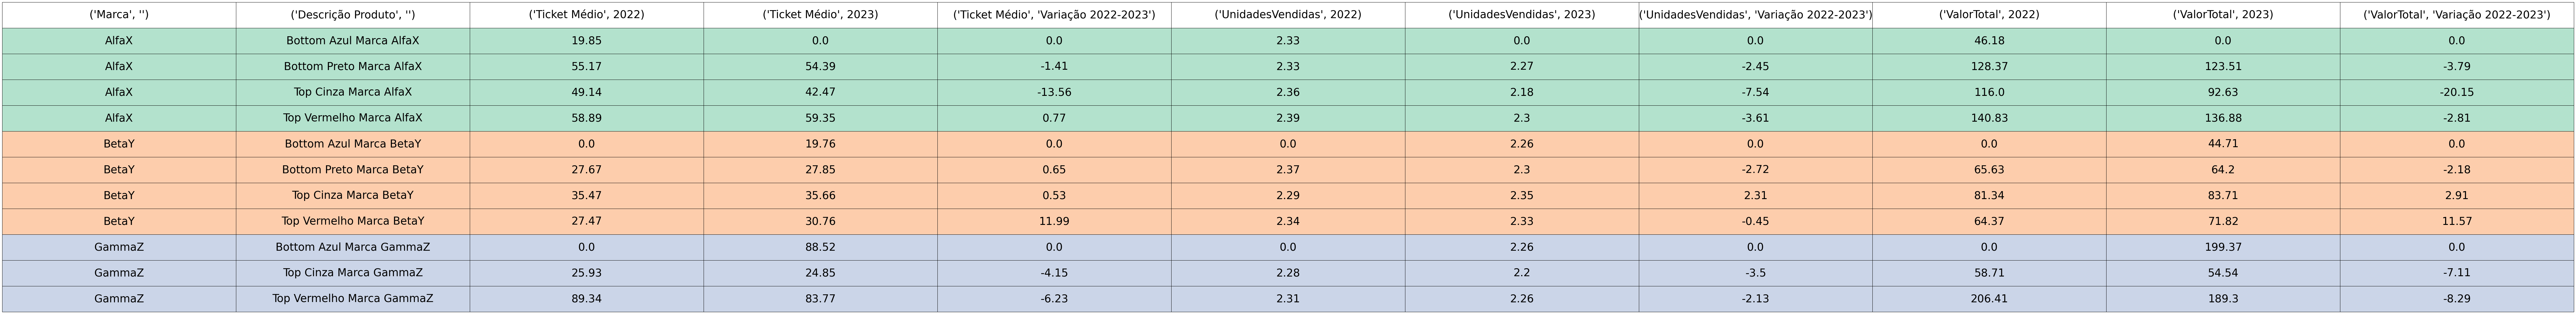

In [20]:
pivot_df = df_tp.pivot_table(index=['Marca', 'Descrição Produto'], columns='Year', values=['Ticket Médio', 'ValorTotal', 'UnidadesVendidas'])
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# pivot_df = df_tp.pivot_table(index=['Marca', 'Descrição Produto'], columns='Year', values=['Ticket Médio', 'ValorTotal', 'UnidadesVendidas'])

for col in ['Ticket Médio', 'ValorTotal', 'UnidadesVendidas']:
    pivot_df[(col, 'Variação 2022-2023')] = ((pivot_df[(col, 2023)] - pivot_df[(col, 2022)]) / pivot_df[(col, 2022)]) * 100

pivot_df = pivot_df.fillna(0)

pivot_df = pivot_df.reindex([
    ('Ticket Médio', 2022),
    ('Ticket Médio', 2023),
    ('Ticket Médio', 'Variação 2022-2023'),
    ('UnidadesVendidas', 2022),
    ('UnidadesVendidas', 2023),
    ('UnidadesVendidas', 'Variação 2022-2023'),
    ('ValorTotal', 2022),
    ('ValorTotal', 2023),
    ('ValorTotal', 'Variação 2022-2023')
], axis=1)

# Defining the figure size
fig, ax = plt.subplots(figsize=(15, 10))  
                       
# Adding the table to the figure
table_data = pivot_df.reset_index().round(2).values.tolist()
column_labels = pivot_df.reset_index().columns.tolist()

# Get the Pastel2 colormap
colors = cm.get_cmap('Pastel2').colors  # This gets the RGBA values of the colors
colors = [cm.colors.to_hex(c) for c in colors]  # This converts the RGBA values to hexadecimal color codes

# Create a color dictionary for each 'Marca'
marca_colors = {marca: colors[i % len(colors)] for i, marca in enumerate(pivot_df.index.get_level_values('Marca').unique())}

# Create a color matrix based on 'Marca'
cell_colors = [[marca_colors[row[0]] for _ in row] for row in table_data]

# Adding the table to the figure
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc = 'center', loc='center', cellColours=cell_colors)

# Adjusting the font size
table.auto_set_font_size(False)
table.set_fontsize(35)  # Increase this value to make the text larger

# Increase the overall width and height of the table
table.scale(10, 7)  # Increase these values to increase the width and height of the columns

# Adjust the font size of the headers
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_fontsize(35)  # Increase this value to make the text larger

# Adjust the font size of 'Marca' and 'Descrição Produto' columns
for key, cell in table.get_celld().items():
    if key[1] in [0, 1]:  # 0 and 1 are the indices of 'Marca' and 'Descrição Produto' columns
        cell.set_fontsize(35)  # Increase this value to make the text larger

# Hiding the axes
ax.axis('off')

# Saving the figure as .png
plt.savefig('pivot_df_table.png')

In [21]:
# liberando espaço na memória
# Get a dictionary of all variables in your current namespace
variables = locals()

# Convert the items to a list before iterating
for var_name, var_value in list(variables.items()):
    if isinstance(var_value, pd.DataFrame) and var_name != 'df_tp':
        del variables[var_name]

##### Terceira parte da análise:
- Clientes e Lojas

###### nesta terceira parte da análise é possível verificar que:

- As lojas 5 (SP), 8 (RS) e 2 (MG) foram as que melhor performaram em relação a Ticket Médio no ano de 2023
- Para estas lojas a Classe B é a com maior Ticket Médio no ano de 2023 e o sexo feminino se destaca neste quesito
- nas faixas etárias há um diferença entre as lojas quando se trata de Ticket Médio no ano de 2023
- - loja 5 -> 18-25
- - loja 8 -> 25-35
- - loja 2 -> 45+
- as tabelas trazem detalhes que podem auxiliar em decisões futuras de MKT de froma mais detalhada
- A primeira loja da tabela é a primeira do Rank (ordenado por Ticket Médio 2023); e assim por diante

In [22]:
import openpyxl
import pandas as pd

# arquivo
wb = openpyxl.load_workbook('Exercicio_Python_CRM .xlsx', read_only=True)

# aba de Cliente
ws = wb['Cliente']

# tamanho do chunk para leitura de bases grandes
chunk_size = 100000
chunks = []

# cabeçalho (nomes das colunas) da primeira linha
header = [cell.value for cell in ws[1]]

# dados em chunks para bases com milhões de linhas
for i in range(2, ws.max_row, chunk_size):  # Comecça de 2 porque a primeira linha é o cabeçalho
    rows = ws[i:i + chunk_size]
    data = [[cell.value for cell in row] for row in rows]
    df = pd.DataFrame(data, columns=header)  # Usando o cabeçalho como nomes das colunas
    chunks.append(df)

# Concatenando os chunks em um único DataFrame
df_c = pd.concat(chunks, axis=0)

# Para cada coluna no DataFrame
for col in df_c.columns:
    # Se o tipo de dados da coluna é object (string)
    if pd.api.types.is_object_dtype(df_c[col]):
        # Remova os espaços em branco no início e no final
        df_c[col] = df_c[col].str.strip()

In [23]:
import openpyxl
import pandas as pd

# arquivo
wb = openpyxl.load_workbook('Exercicio_Python_CRM .xlsx', read_only=True)

# aba de Cliente
ws = wb['Lojas']

# tamanho do chunk para leitura de bases grandes
chunk_size = 100000
chunks = []

# cabeçalho (nomes das colunas) da primeira linha
header = [cell.value for cell in ws[1]]

# dados em chunks para bases com milhões de linhas
for i in range(2, ws.max_row, chunk_size):  # Comecça de 2 porque a primeira linha é o cabeçalho
    rows = ws[i:i + chunk_size]
    data = [[cell.value for cell in row] for row in rows]
    df = pd.DataFrame(data, columns=header)  # Usando o cabeçalho como nomes das colunas
    chunks.append(df)

# Concatenando os chunks em um único DataFrame
df_l = pd.concat(chunks, axis=0)

# Para cada coluna no DataFrame
for col in df_l.columns:
    # Se o tipo de dados da coluna é object (string)
    if pd.api.types.is_object_dtype(df_l[col]):
        # Remova os espaços em branco no início e no final
        df_l[col] = df_l[col].str.strip()

In [24]:
# If 'Regiao' is None and 'UF' is 'SP', set 'Regiao' to 'SUDESTE'
df_l.loc[(df_l['Regiao'].isnull()) & (df_l['UF'] == 'SP'), 'Regiao'] = 'SUDESTE'
# If 'Regiao' is None and 'UF' is 'BH', set 'Regiao' to 'SUDESTE'
df_l.loc[(df_l['Regiao'].isnull()) & (df_l['UF'] == 'BH'), 'Regiao'] = 'SUDESTE'
df_merged = df_tp.merge(df_l, on='ID_Loja', how='left')
df_final = df_merged.merge(df_c, left_on='ID_Cliente', right_on='CustomerID', how='left')

# liberando espaço na memória
# Get a dictionary of all variables in your current namespace
variables = locals()

# Convert the items to a list before iterating
for var_name, var_value in list(variables.items()):
    if isinstance(var_value, pd.DataFrame) and var_name != 'df_final':
        del variables[var_name]

Ticket Médio por ID_Loja e Ano - a barra em vermelho indica a Loja 5 com melhor Ticket Médio agregado no ano 2023 (agregado te todos os produtos)

In [25]:
# Group by 'ID_Loja' and 'Year' and calculate the mean of 'Ticket Médio', 'ValorTotal', and 'UnidadesVendidas'
df_grouped = df_final.groupby(['ID_Loja', 'Year']).agg({'Ticket Médio': 'mean', 'ValorTotal': 'sum', 'UnidadesVendidas': 'sum'})

# Rank 'ID_Loja' by 'Ticket Médio', 'ValorTotal', and 'UnidadesVendidas' for each year
df_grouped['Rank_Ticket_Medio'] = df_grouped.groupby('Year')['Ticket Médio'].rank(ascending=False)
df_grouped['Rank_ValorTotal'] = df_grouped.groupby('Year')['ValorTotal'].rank(ascending=False)
df_grouped['Rank_UnidadesVendidas'] = df_grouped.groupby('Year')['UnidadesVendidas'].rank(ascending=False)
# Sort df_grouped by 'ID_Loja', 'Year' and 'Rank_Ticket_Medio'
df_sorted = df_grouped.sort_values(by=['ID_Loja', 'Rank_Ticket_Medio', 'Year'])


import plotly.graph_objects as go

# Reset the index
df_sorted_reset = df_sorted.reset_index()

# Create a color sequence similar to 'Pastel2'
color_sequence = ['#b3e2cd', '#fdcdac', '#cbd5e8', '#f4cae4', '#e6f5c9', '#fff2ae']

# Get the 'ID_Loja' with the best rank in 2023
best_rank_id_loja_2023 = df_sorted_reset[(df_sorted_reset['Year'] == 2023) & (df_sorted_reset['Rank_Ticket_Medio'] == df_sorted_reset['Rank_Ticket_Medio'].min())]['ID_Loja'].values[0]

# Create a bar plot
fig = go.Figure()

for i, year in enumerate(df_sorted_reset['Year'].unique()):
    df_year = df_sorted_reset[df_sorted_reset['Year'] == year]
    fig.add_trace(go.Bar(
        x=df_year['ID_Loja'],
        y=df_year['Ticket Médio'],
        name=str(year),
        text=df_year['Rank_Ticket_Medio'],
        legendgroup=str(year),
        marker_color=[color_sequence[i % len(color_sequence)] if id_loja != best_rank_id_loja_2023 or year != 2023 else '#ff0000' for id_loja in df_year['ID_Loja']],  # Highlight the best rank in 2023
        hovertemplate='ID_Loja: %{x}<br>Ticket Médio: %{y}<br>Year: '+str(year)+'<br>Rank: %{text}<extra></extra>',
    ))

# Add title and set barmode to 'group'
fig.update_layout(title_text='Ticket Médio por ID_Loja e Ano', barmode='group')

# Show the plot
fig.show()


In [26]:
df_grouped_unique = df_final.groupby(['ID_Loja', 'Year','Marca']).agg({'Ticket Médio': 'mean',
    'UnidadesVendidas': 'sum',
    'ValorTotal': 'sum'})
df_pivot = df_grouped_unique.reset_index().pivot_table(index=['ID_Loja', 'Marca'], columns='Year', values=['Ticket Médio', 'UnidadesVendidas', 'ValorTotal'])


df_sorted_2023 = df_sorted.loc[(slice(None), 2023), ['Rank_Ticket_Medio']]
df_sorted_2023_sorted = df_sorted_2023.sort_values(by='Rank_Ticket_Medio')
id_loja_list = df_sorted_2023_sorted.index.get_level_values('ID_Loja').tolist()


df_pivot_reindexed = df_pivot.reindex(id_loja_list, level='ID_Loja')
#df_pivot_reindexed

- Loja e Marca - Rank por Ticket médio 2023

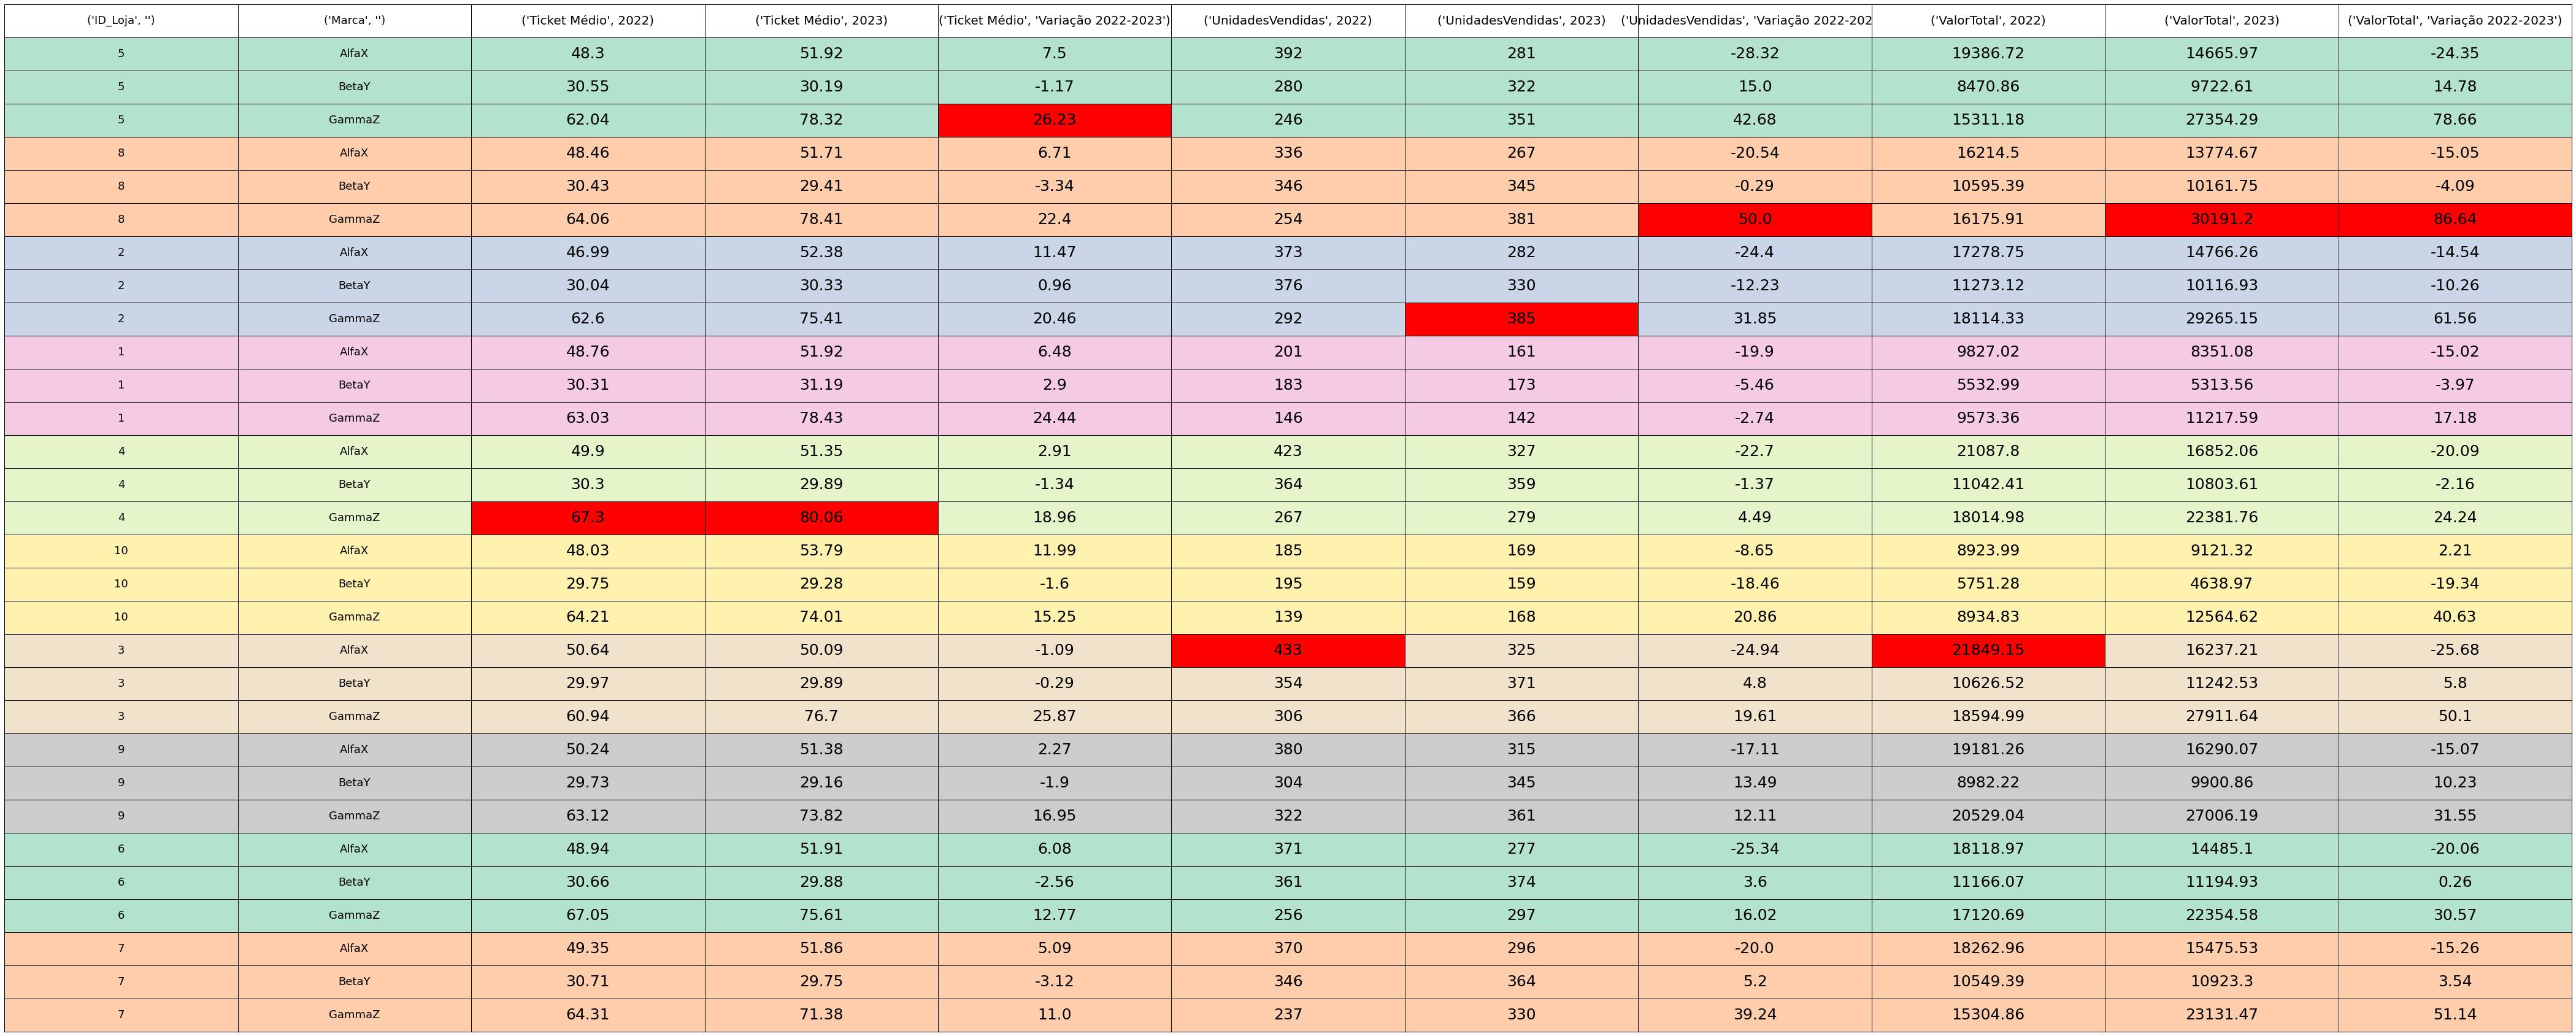

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the variation for each column
for col in ['Ticket Médio', 'ValorTotal', 'UnidadesVendidas']:
    df_pivot_reindexed[(col, 'Variação 2022-2023')] = ((df_pivot_reindexed[(col, 2023)] - df_pivot_reindexed[(col, 2022)]) / df_pivot_reindexed[(col, 2022)]) * 100

# Fill NaN values with 0
df_pivot_reindexed = df_pivot_reindexed.fillna(0)

# Reindex the columns
df_pivot_reindexed = df_pivot_reindexed.reindex([
    ('Ticket Médio', 2022),
    ('Ticket Médio', 2023),
    ('Ticket Médio', 'Variação 2022-2023'),
    ('UnidadesVendidas', 2022),
    ('UnidadesVendidas', 2023),
    ('UnidadesVendidas', 'Variação 2022-2023'),
    ('ValorTotal', 2022),
    ('ValorTotal', 2023),
    ('ValorTotal', 'Variação 2022-2023')
], axis=1)

# Define the figure size
fig, ax = plt.subplots(figsize=(15, 10))

# Add the table to the figure
table_data = df_pivot_reindexed.reset_index().round(2).values.tolist()
column_labels = df_pivot_reindexed.reset_index().columns.tolist()

# Create a color dictionary for each 'ID_Loja'
id_loja_colors = {id_loja: colors[i % len(colors)] for i, id_loja in enumerate(df_pivot_reindexed.index.get_level_values('ID_Loja').unique())}

# Create a color matrix based on 'ID_Loja'
cell_colors = [[id_loja_colors[row[0]] for _ in row] for row in table_data]

# Highlight the largest numbers in each column, skipping the first two columns
for i in range(2, len(table_data[0])):
    column_data = [row[i] for row in table_data]
    max_value = max(column_data)
    for j in range(len(table_data)):
        if table_data[j][i] == max_value:
            cell_colors[j][i] = 'red'  # Change 'red' to any color you want

# Add the table to the figure
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center', cellColours=cell_colors)

# Adjust the font size
table.auto_set_font_size(False)
table.set_fontsize(16)

# Increase the overall width and height of the table
table.scale(5, 4.5)

# Increase the font size
table.set_fontsize(25)

# Adjust the font size of the headers
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_fontsize(20)

# Adjust the font size of 'ID_Loja' and 'Marca' columns
for key, cell in table.get_celld().items():
    if key[1] in [0, 1]:
        cell.set_fontsize(18)

# Hide the axes
ax.axis('off')

# Save the figure as .png
plt.savefig('df_pivot_reindexed_table.png')

- Loja e UF - Rank por Ticket médio 2023

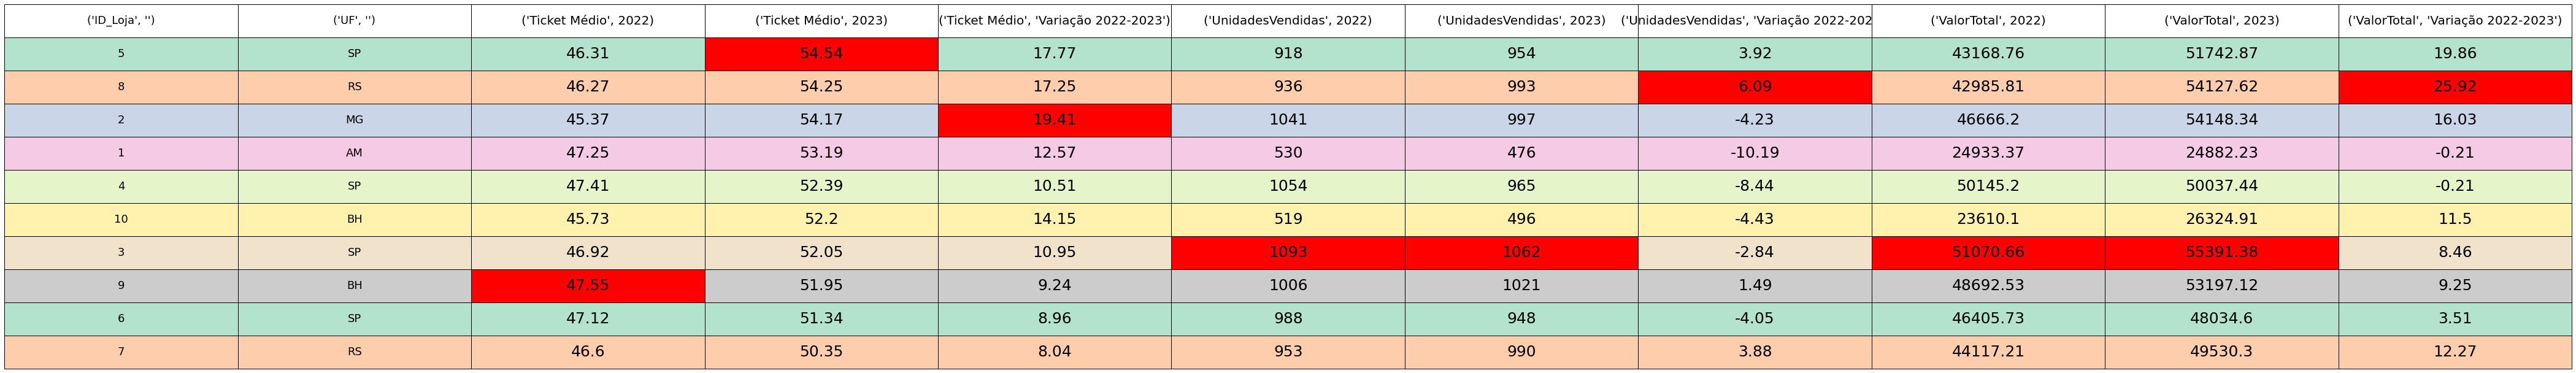

In [28]:
df_grouped_unique = df_final.groupby(['ID_Loja', 'Year','UF']).agg({'Ticket Médio': 'mean',
    'UnidadesVendidas': 'sum',
    'ValorTotal': 'sum'})
df_pivot = df_grouped_unique.reset_index().pivot_table(index=['ID_Loja', 'UF'], columns='Year', values=['Ticket Médio', 'UnidadesVendidas', 'ValorTotal'])


df_sorted_2023 = df_sorted.loc[(slice(None), 2023), ['Rank_Ticket_Medio']]
df_sorted_2023_sorted = df_sorted_2023.sort_values(by='Rank_Ticket_Medio')
id_loja_list = df_sorted_2023_sorted.index.get_level_values('ID_Loja').tolist()


df_pivot_reindexed = df_pivot.reindex(id_loja_list, level='ID_Loja')


import matplotlib.pyplot as plt
import numpy as np

# Calculate the variation for each column
for col in ['Ticket Médio', 'ValorTotal', 'UnidadesVendidas']:
    df_pivot_reindexed[(col, 'Variação 2022-2023')] = ((df_pivot_reindexed[(col, 2023)] - df_pivot_reindexed[(col, 2022)]) / df_pivot_reindexed[(col, 2022)]) * 100

# Fill NaN values with 0
df_pivot_reindexed = df_pivot_reindexed.fillna(0)

# Reindex the columns
df_pivot_reindexed = df_pivot_reindexed.reindex([
    ('Ticket Médio', 2022),
    ('Ticket Médio', 2023),
    ('Ticket Médio', 'Variação 2022-2023'),
    ('UnidadesVendidas', 2022),
    ('UnidadesVendidas', 2023),
    ('UnidadesVendidas', 'Variação 2022-2023'),
    ('ValorTotal', 2022),
    ('ValorTotal', 2023),
    ('ValorTotal', 'Variação 2022-2023')
], axis=1)

# Define the figure size
fig, ax = plt.subplots(figsize=(15, 10))

# Add the table to the figure
table_data = df_pivot_reindexed.reset_index().round(2).values.tolist()
column_labels = df_pivot_reindexed.reset_index().columns.tolist()

# Create a color dictionary for each 'ID_Loja'
id_loja_colors = {id_loja: colors[i % len(colors)] for i, id_loja in enumerate(df_pivot_reindexed.index.get_level_values('ID_Loja').unique())}

# Create a color matrix based on 'ID_Loja'
cell_colors = [[id_loja_colors[row[0]] for _ in row] for row in table_data]

# Highlight the largest numbers in each column, skipping the first two columns
for i in range(2, len(table_data[0])):
    column_data = [row[i] for row in table_data]
    max_value = max(column_data)
    for j in range(len(table_data)):
        if table_data[j][i] == max_value:
            cell_colors[j][i] = 'red'  # Change 'red' to any color you want

# Add the table to the figure
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center', cellColours=cell_colors)

# Adjust the font size
table.auto_set_font_size(False)
table.set_fontsize(16)

# Increase the overall width and height of the table
table.scale(5, 4.5)

# Increase the font size
table.set_fontsize(25)

# Adjust the font size of the headers
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_fontsize(20)

# Adjust the font size of 'ID_Loja' and 'UF' columns
for key, cell in table.get_celld().items():
    if key[1] in [0, 1]:
        cell.set_fontsize(18)

# Hide the axes
ax.axis('off')

# Save the figure as .png
plt.savefig('df_pivot_reindexed_table.png')



- Loja e Classe Social - Rank por Ticket médio 2023

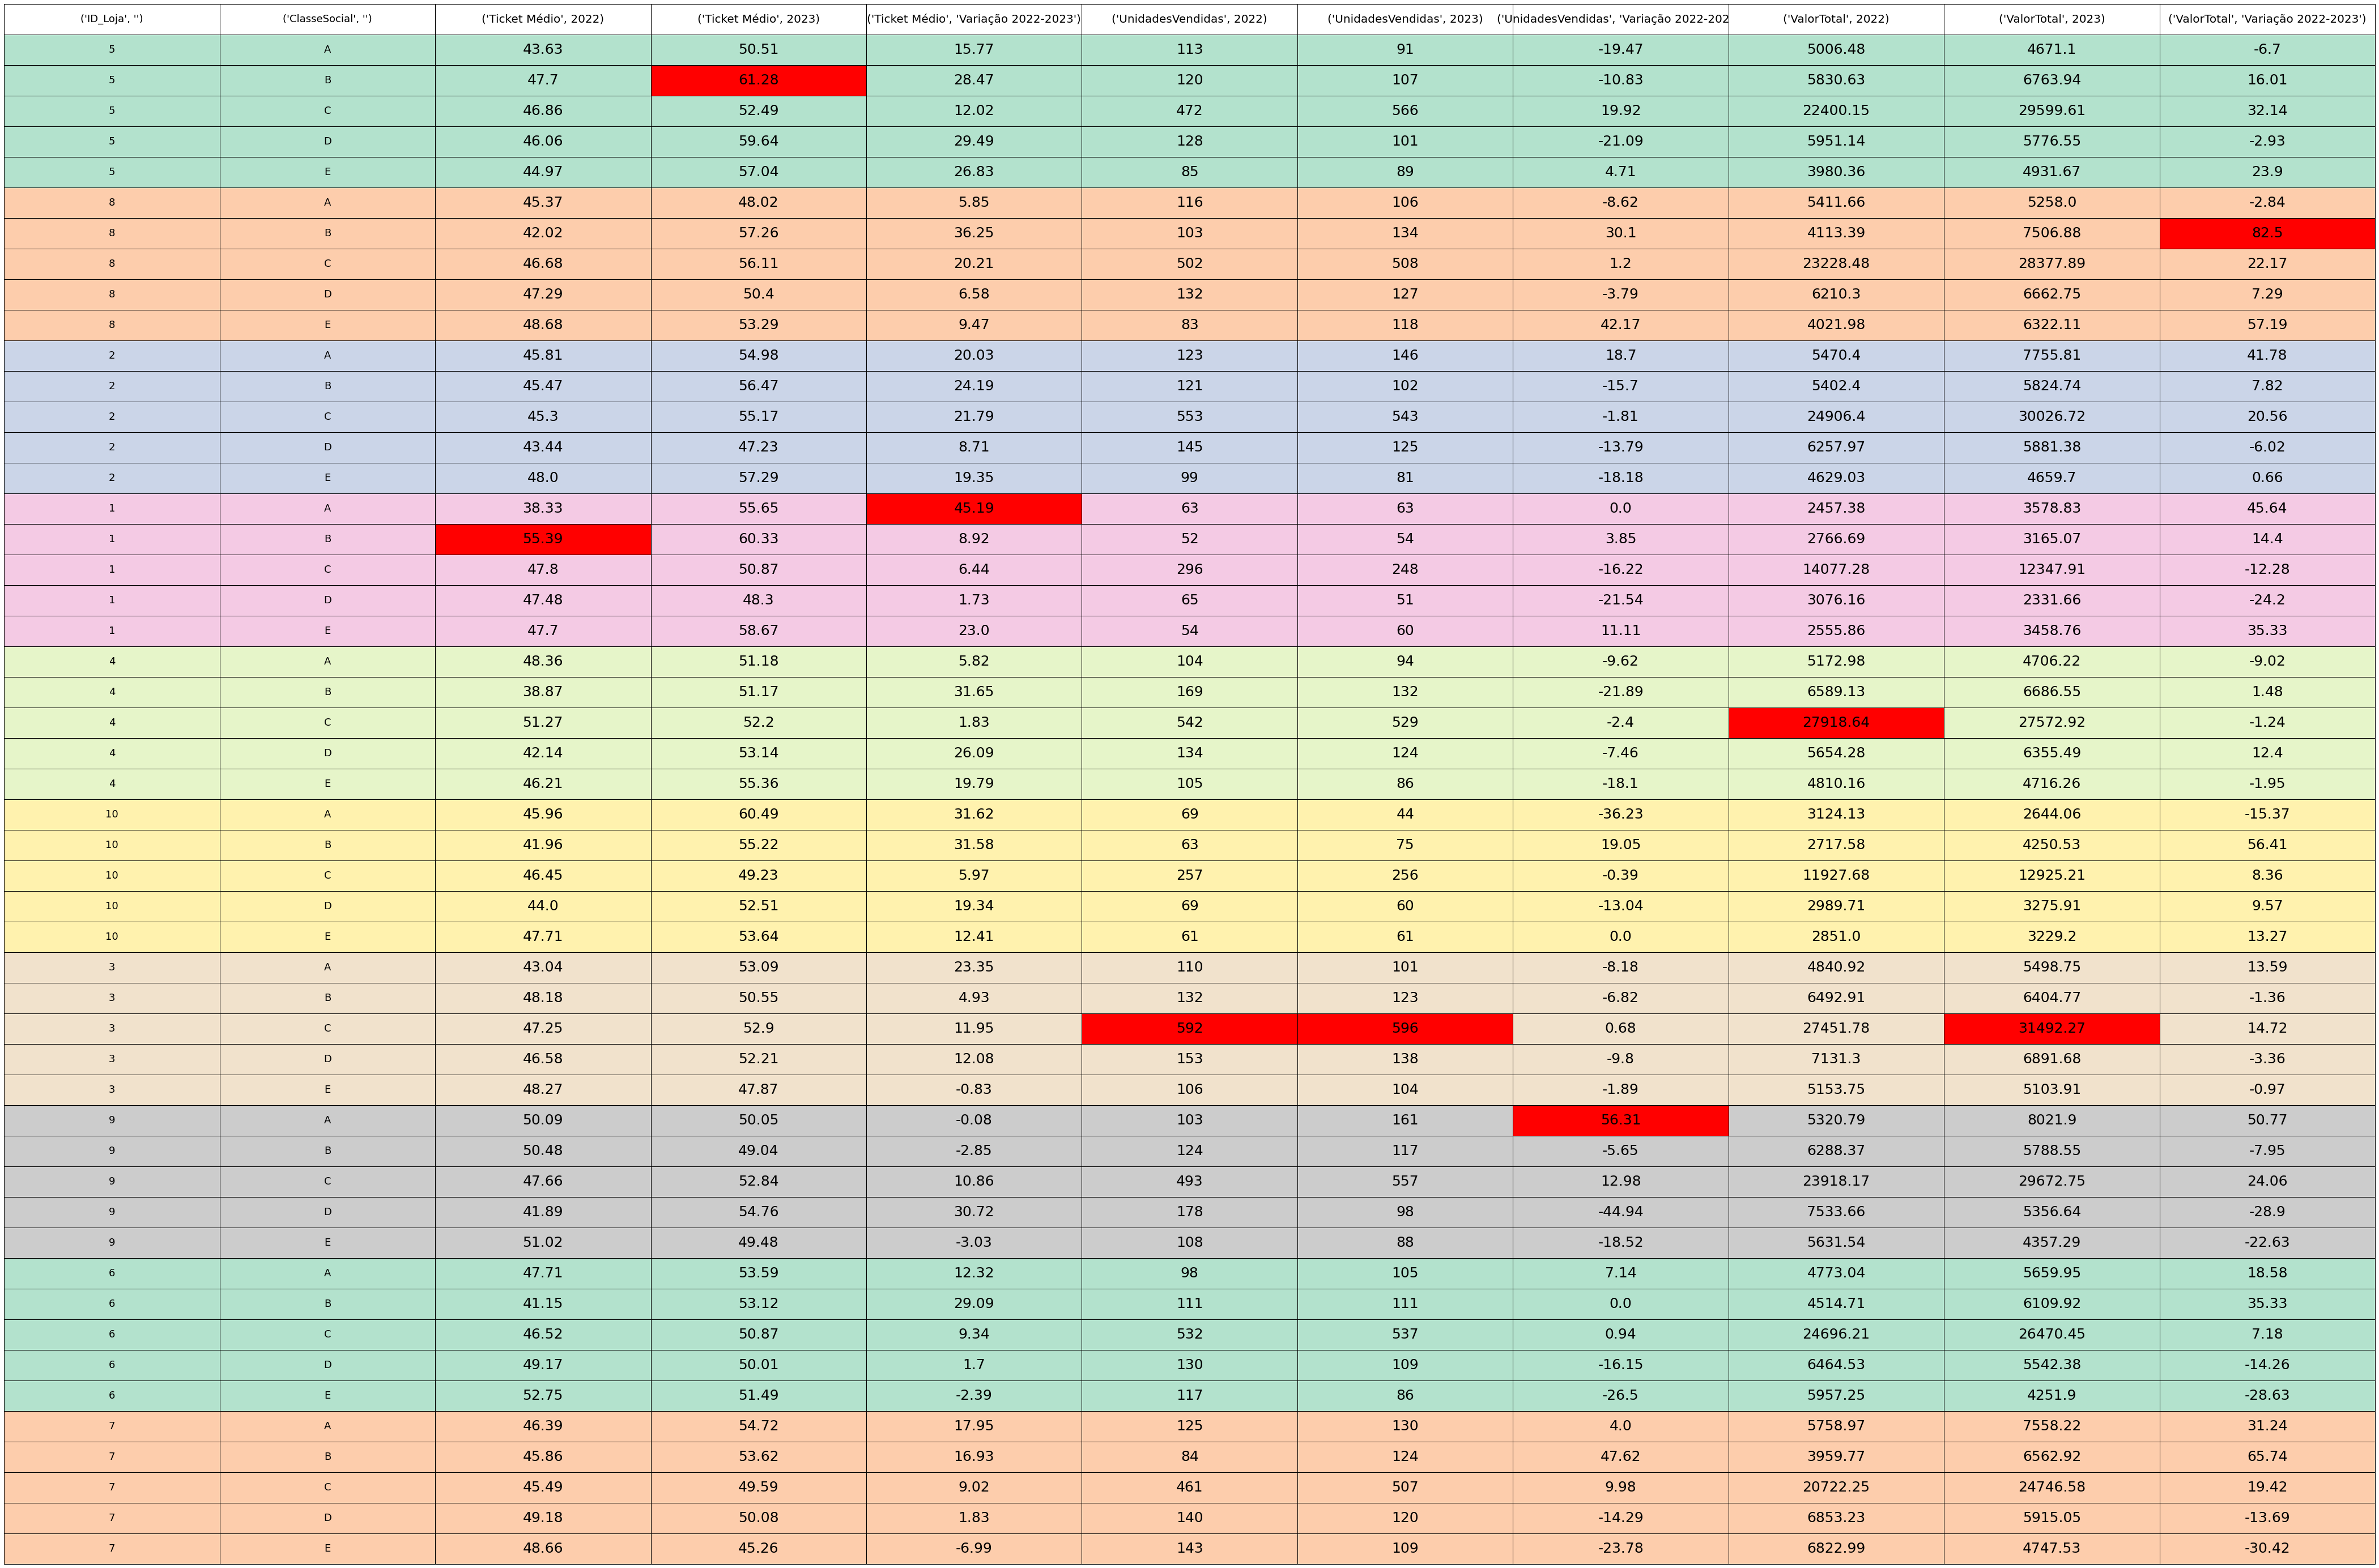

In [29]:
df_grouped_unique = df_final.groupby(['ID_Loja', 'Year','ClasseSocial']).agg({'Ticket Médio': 'mean',
    'UnidadesVendidas': 'sum',
    'ValorTotal': 'sum'})
df_pivot = df_grouped_unique.reset_index().pivot_table(index=['ID_Loja', 'ClasseSocial'], columns='Year', values=['Ticket Médio', 'UnidadesVendidas', 'ValorTotal'])


df_sorted_2023 = df_sorted.loc[(slice(None), 2023), ['Rank_Ticket_Medio']]
df_sorted_2023_sorted = df_sorted_2023.sort_values(by='Rank_Ticket_Medio')
id_loja_list = df_sorted_2023_sorted.index.get_level_values('ID_Loja').tolist()


df_pivot_reindexed = df_pivot.reindex(id_loja_list, level='ID_Loja')


import matplotlib.pyplot as plt
import numpy as np

# Calculate the variation for each column
for col in ['Ticket Médio', 'ValorTotal', 'UnidadesVendidas']:
    df_pivot_reindexed[(col, 'Variação 2022-2023')] = ((df_pivot_reindexed[(col, 2023)] - df_pivot_reindexed[(col, 2022)]) / df_pivot_reindexed[(col, 2022)]) * 100

# Fill NaN values with 0
df_pivot_reindexed = df_pivot_reindexed.fillna(0)

# Reindex the columns
df_pivot_reindexed = df_pivot_reindexed.reindex([
    ('Ticket Médio', 2022),
    ('Ticket Médio', 2023),
    ('Ticket Médio', 'Variação 2022-2023'),
    ('UnidadesVendidas', 2022),
    ('UnidadesVendidas', 2023),
    ('UnidadesVendidas', 'Variação 2022-2023'),
    ('ValorTotal', 2022),
    ('ValorTotal', 2023),
    ('ValorTotal', 'Variação 2022-2023')
], axis=1)

# Define the figure size
fig, ax = plt.subplots(figsize=(15, 10))

# Add the table to the figure
table_data = df_pivot_reindexed.reset_index().round(2).values.tolist()
column_labels = df_pivot_reindexed.reset_index().columns.tolist()

# Create a color dictionary for each 'ID_Loja'
id_loja_colors = {id_loja: colors[i % len(colors)] for i, id_loja in enumerate(df_pivot_reindexed.index.get_level_values('ID_Loja').unique())}

# Create a color matrix based on 'ID_Loja'
cell_colors = [[id_loja_colors[row[0]] for _ in row] for row in table_data]

# Highlight the largest numbers in each column, skipping the first two columns
for i in range(2, len(table_data[0])):
    column_data = [row[i] for row in table_data]
    max_value = max(column_data)
    for j in range(len(table_data)):
        if table_data[j][i] == max_value:
            cell_colors[j][i] = 'red'  # Change 'red' to any color you want

# Add the table to the figure
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center', cellColours=cell_colors)

# Adjust the font size
table.auto_set_font_size(False)
table.set_fontsize(16)

# Increase the overall width and height of the table
table.scale(5, 4.5)

# Increase the font size
table.set_fontsize(25)

# Adjust the font size of the headers
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_fontsize(20)

# Adjust the font size of 'ID_Loja' and 'ClasseSocial' columns
for key, cell in table.get_celld().items():
    if key[1] in [0, 1]:
        cell.set_fontsize(18)

# Hide the axes
ax.axis('off')

# Save the figure as .png
plt.savefig('df_pivot_reindexed_table.png')



- Loja e Genero - Rank por Ticket médio 2023

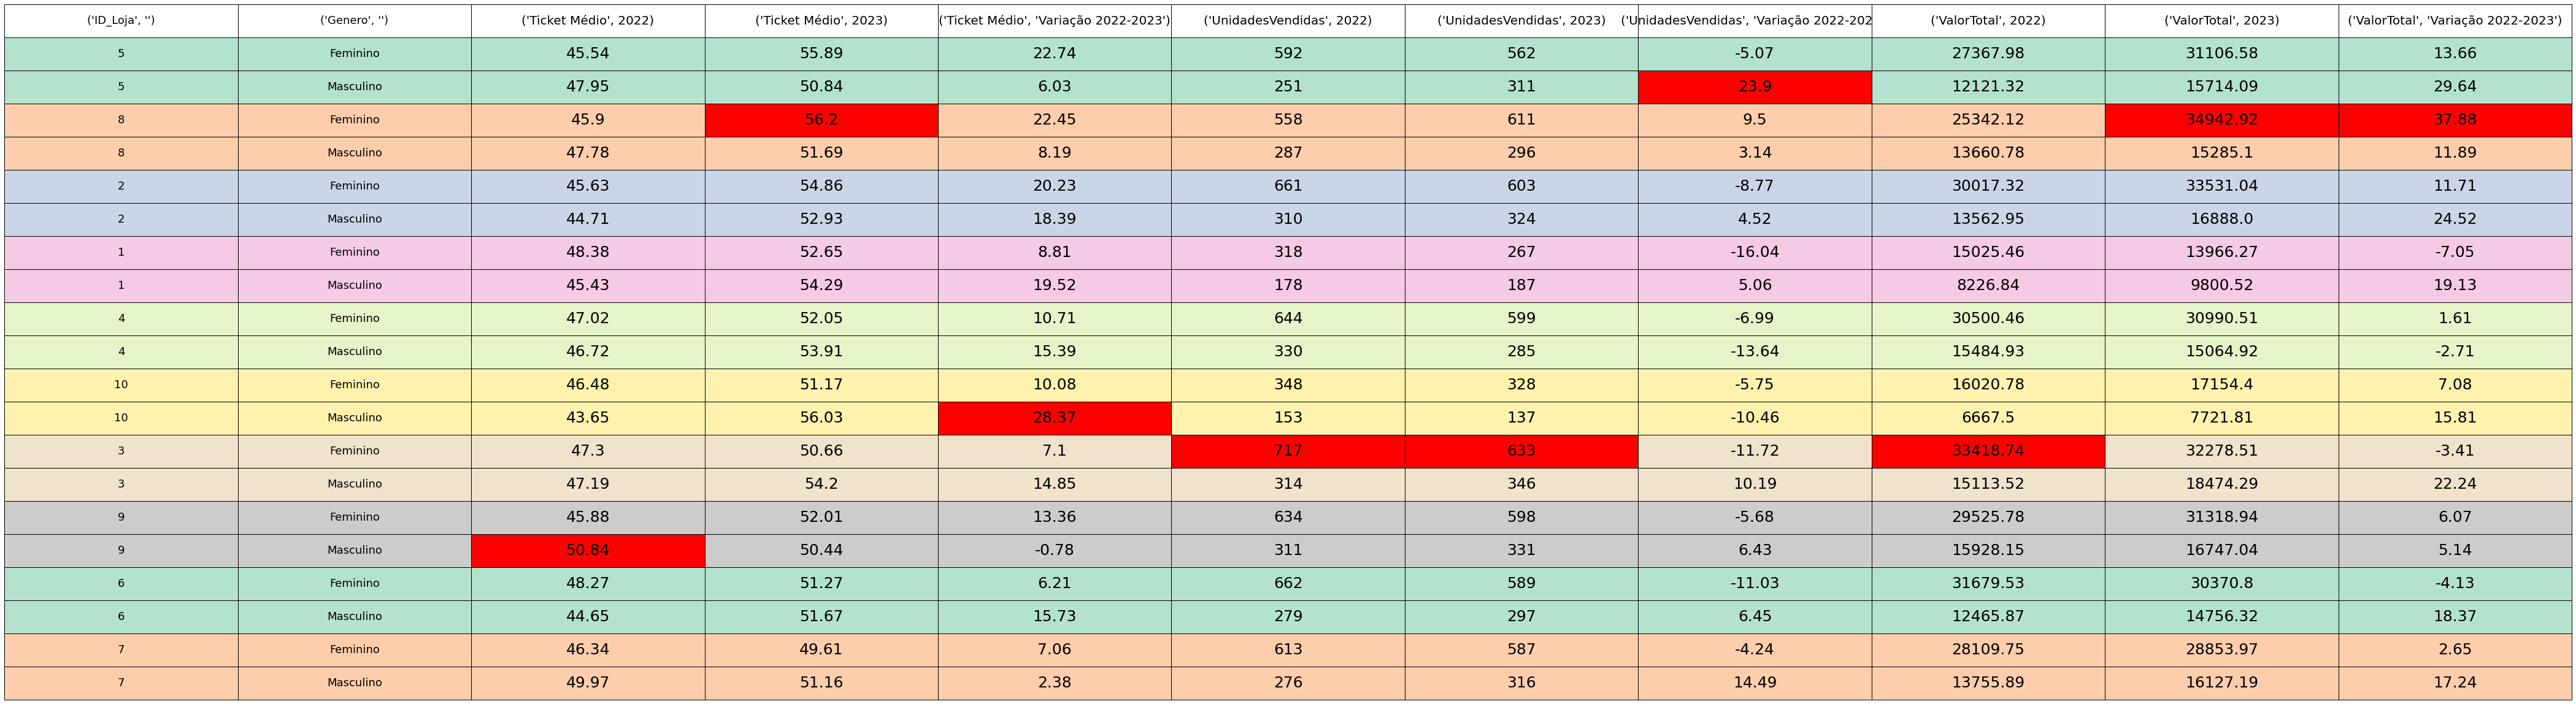

In [30]:
df_grouped_unique = df_final.groupby(['ID_Loja', 'Year','Genero']).agg({'Ticket Médio': 'mean',
    'UnidadesVendidas': 'sum',
    'ValorTotal': 'sum'})
df_pivot = df_grouped_unique.reset_index().pivot_table(index=['ID_Loja', 'Genero'], columns='Year', values=['Ticket Médio', 'UnidadesVendidas', 'ValorTotal'])


df_sorted_2023 = df_sorted.loc[(slice(None), 2023), ['Rank_Ticket_Medio']]
df_sorted_2023_sorted = df_sorted_2023.sort_values(by='Rank_Ticket_Medio')
id_loja_list = df_sorted_2023_sorted.index.get_level_values('ID_Loja').tolist()


df_pivot_reindexed = df_pivot.reindex(id_loja_list, level='ID_Loja')


import matplotlib.pyplot as plt
import numpy as np

# Calculate the variation for each column
for col in ['Ticket Médio', 'ValorTotal', 'UnidadesVendidas']:
    df_pivot_reindexed[(col, 'Variação 2022-2023')] = ((df_pivot_reindexed[(col, 2023)] - df_pivot_reindexed[(col, 2022)]) / df_pivot_reindexed[(col, 2022)]) * 100

# Fill NaN values with 0
df_pivot_reindexed = df_pivot_reindexed.fillna(0)

# Reindex the columns
df_pivot_reindexed = df_pivot_reindexed.reindex([
    ('Ticket Médio', 2022),
    ('Ticket Médio', 2023),
    ('Ticket Médio', 'Variação 2022-2023'),
    ('UnidadesVendidas', 2022),
    ('UnidadesVendidas', 2023),
    ('UnidadesVendidas', 'Variação 2022-2023'),
    ('ValorTotal', 2022),
    ('ValorTotal', 2023),
    ('ValorTotal', 'Variação 2022-2023')
], axis=1)

# Define the figure size
fig, ax = plt.subplots(figsize=(15, 10))

# Add the table to the figure
table_data = df_pivot_reindexed.reset_index().round(2).values.tolist()
column_labels = df_pivot_reindexed.reset_index().columns.tolist()

# Create a color dictionary for each 'ID_Loja'
id_loja_colors = {id_loja: colors[i % len(colors)] for i, id_loja in enumerate(df_pivot_reindexed.index.get_level_values('ID_Loja').unique())}

# Create a color matrix based on 'ID_Loja'
cell_colors = [[id_loja_colors[row[0]] for _ in row] for row in table_data]

# Highlight the largest numbers in each column, skipping the first two columns
for i in range(2, len(table_data[0])):
    column_data = [row[i] for row in table_data]
    max_value = max(column_data)
    for j in range(len(table_data)):
        if table_data[j][i] == max_value:
            cell_colors[j][i] = 'red'  # Change 'red' to any color you want

# Add the table to the figure
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center', cellColours=cell_colors)

# Adjust the font size
table.auto_set_font_size(False)
table.set_fontsize(16)

# Increase the overall width and height of the table
table.scale(5, 4.5)

# Increase the font size
table.set_fontsize(25)

# Adjust the font size of the headers
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_fontsize(20)

# Adjust the font size of 'ID_Loja' and 'Genero' columns
for key, cell in table.get_celld().items():
    if key[1] in [0, 1]:
        cell.set_fontsize(18)

# Hide the axes
ax.axis('off')

# Save the figure as .png
plt.savefig('df_pivot_reindexed_table.png')



- Loja e Faixa de Idade - Rank por Ticket médio 2023

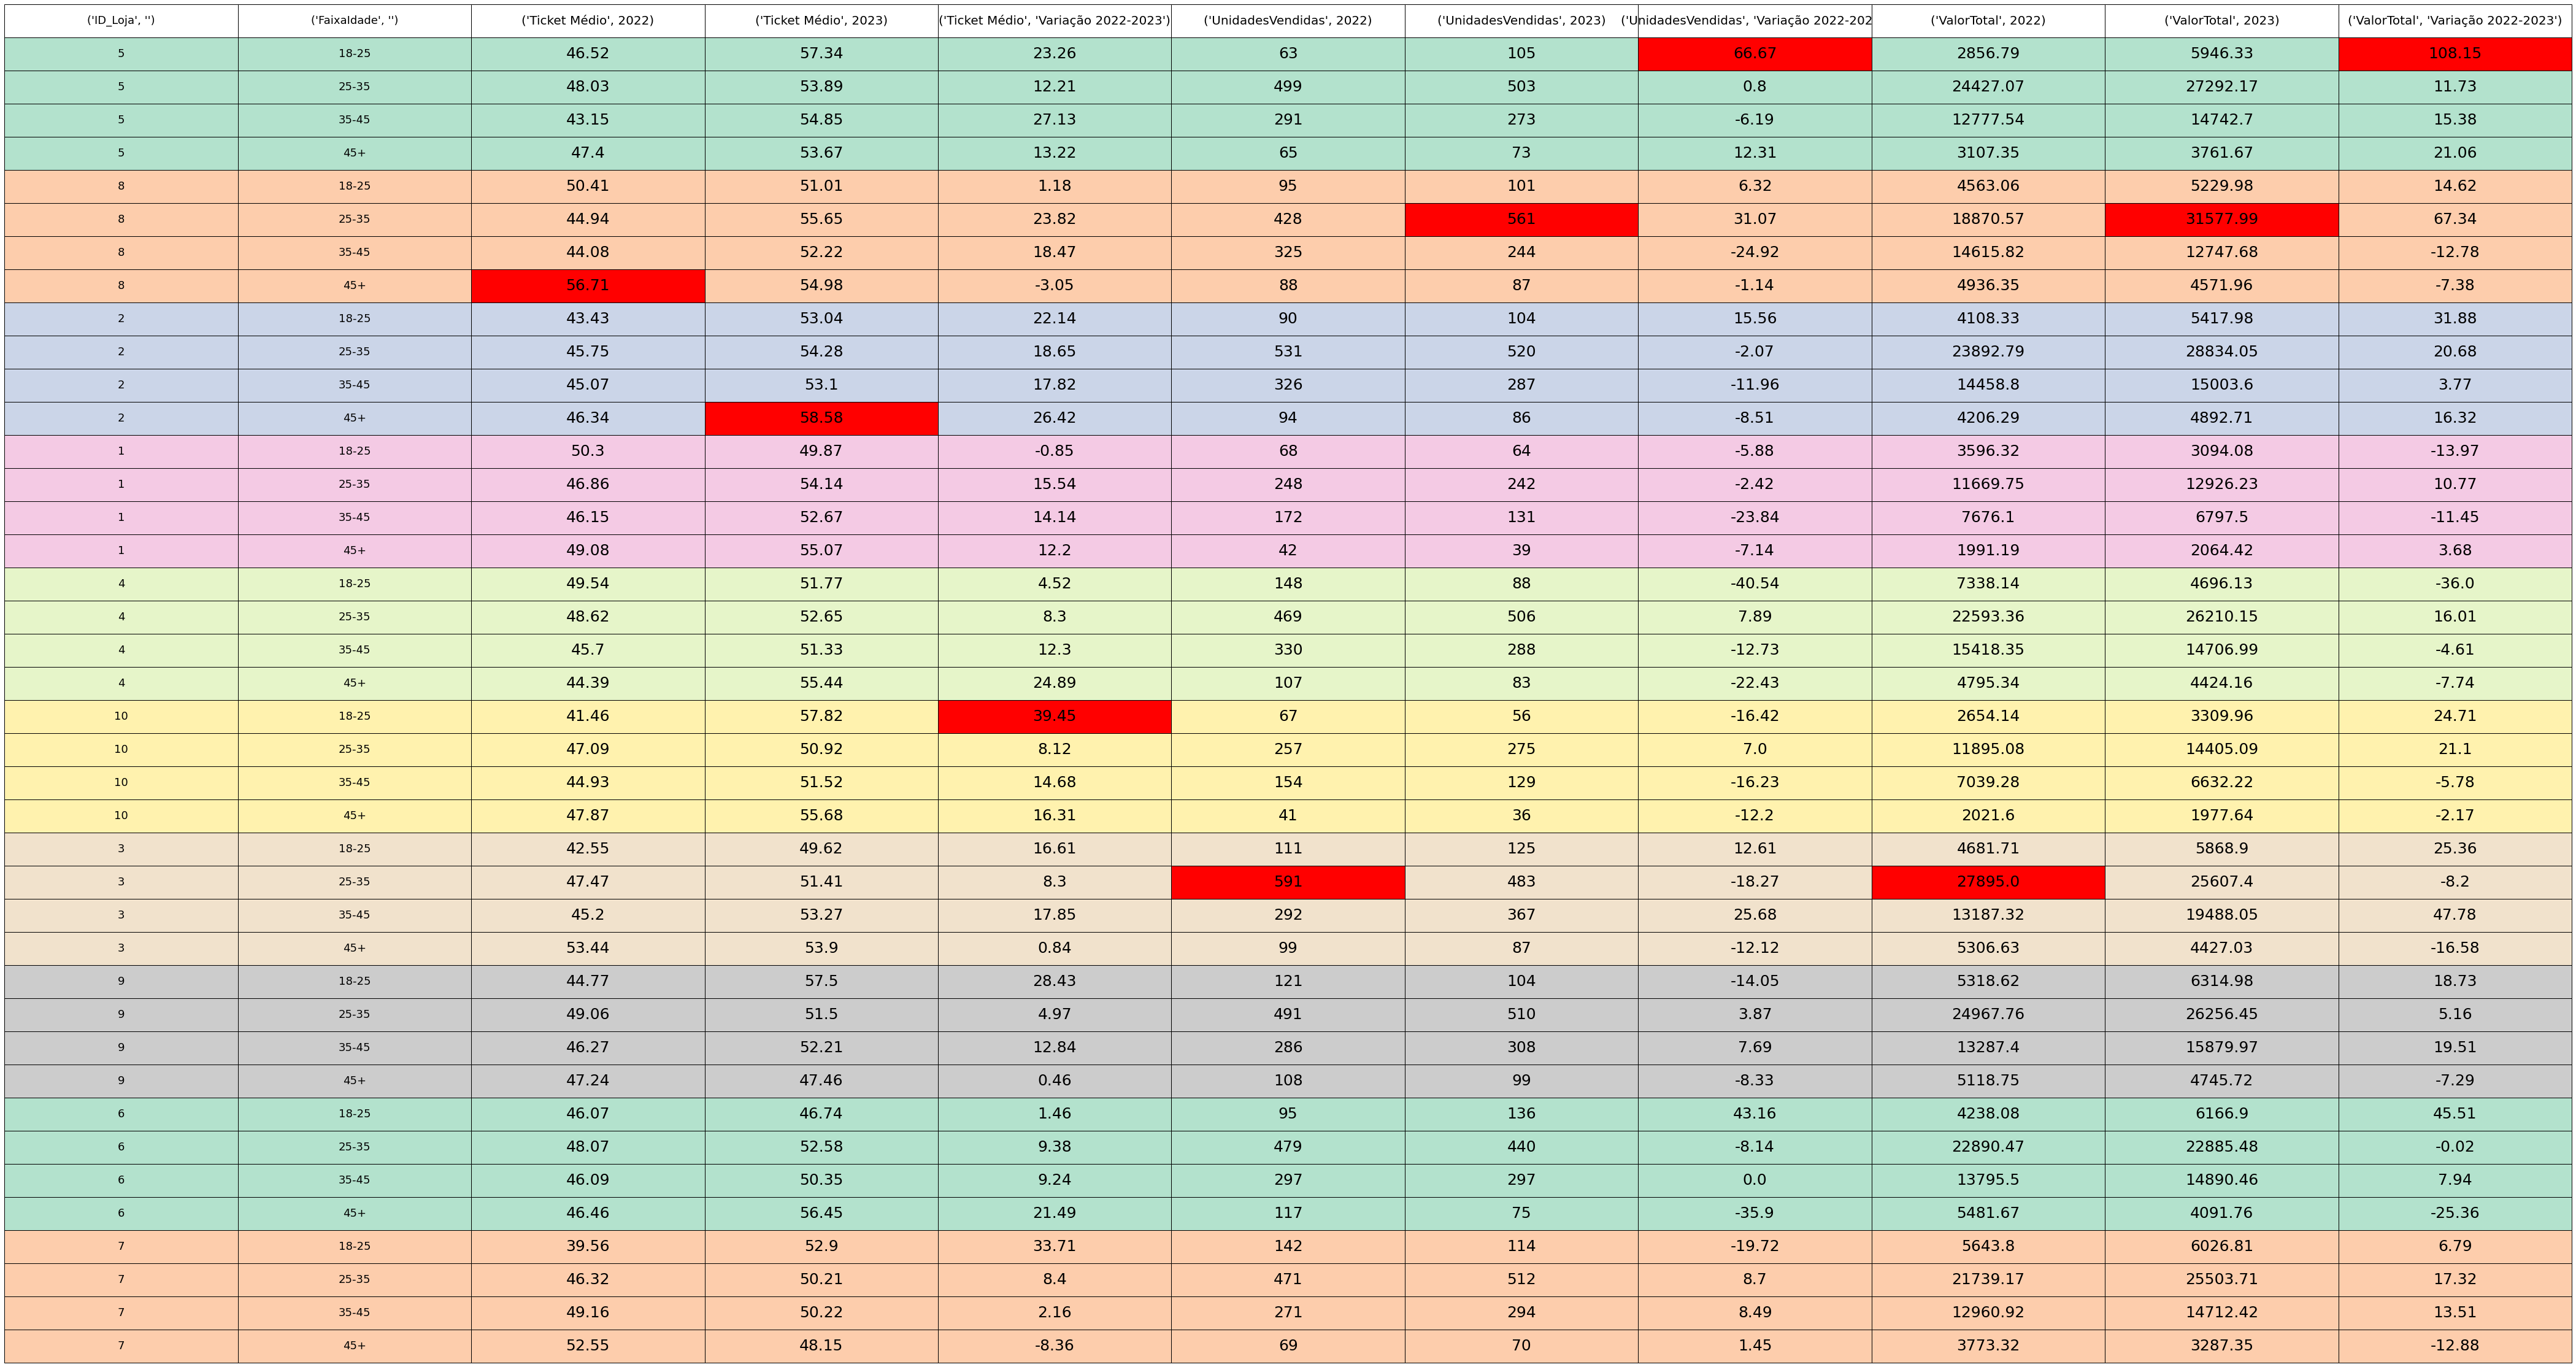

In [31]:
df_grouped_unique = df_final.groupby(['ID_Loja', 'Year','FaixaIdade']).agg({'Ticket Médio': 'mean',
    'UnidadesVendidas': 'sum',
    'ValorTotal': 'sum'})
df_pivot = df_grouped_unique.reset_index().pivot_table(index=['ID_Loja', 'FaixaIdade'], columns='Year', values=['Ticket Médio', 'UnidadesVendidas', 'ValorTotal'])


df_sorted_2023 = df_sorted.loc[(slice(None), 2023), ['Rank_Ticket_Medio']]
df_sorted_2023_sorted = df_sorted_2023.sort_values(by='Rank_Ticket_Medio')
id_loja_list = df_sorted_2023_sorted.index.get_level_values('ID_Loja').tolist()


df_pivot_reindexed = df_pivot.reindex(id_loja_list, level='ID_Loja')


import matplotlib.pyplot as plt
import numpy as np

# Calculate the variation for each column
for col in ['Ticket Médio', 'ValorTotal', 'UnidadesVendidas']:
    df_pivot_reindexed[(col, 'Variação 2022-2023')] = ((df_pivot_reindexed[(col, 2023)] - df_pivot_reindexed[(col, 2022)]) / df_pivot_reindexed[(col, 2022)]) * 100

# Fill NaN values with 0
df_pivot_reindexed = df_pivot_reindexed.fillna(0)

# Reindex the columns
df_pivot_reindexed = df_pivot_reindexed.reindex([
    ('Ticket Médio', 2022),
    ('Ticket Médio', 2023),
    ('Ticket Médio', 'Variação 2022-2023'),
    ('UnidadesVendidas', 2022),
    ('UnidadesVendidas', 2023),
    ('UnidadesVendidas', 'Variação 2022-2023'),
    ('ValorTotal', 2022),
    ('ValorTotal', 2023),
    ('ValorTotal', 'Variação 2022-2023')
], axis=1)

# Define the figure size
fig, ax = plt.subplots(figsize=(15, 10))

# Add the table to the figure
table_data = df_pivot_reindexed.reset_index().round(2).values.tolist()
column_labels = df_pivot_reindexed.reset_index().columns.tolist()

# Create a color dictionary for each 'ID_Loja'
id_loja_colors = {id_loja: colors[i % len(colors)] for i, id_loja in enumerate(df_pivot_reindexed.index.get_level_values('ID_Loja').unique())}

# Create a color matrix based on 'ID_Loja'
cell_colors = [[id_loja_colors[row[0]] for _ in row] for row in table_data]

# Highlight the largest numbers in each column, skipping the first two columns
for i in range(2, len(table_data[0])):
    column_data = [row[i] for row in table_data]
    max_value = max(column_data)
    for j in range(len(table_data)):
        if table_data[j][i] == max_value:
            cell_colors[j][i] = 'red'  # Change 'red' to any color you want

# Add the table to the figure
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center', cellColours=cell_colors)

# Adjust the font size
table.auto_set_font_size(False)
table.set_fontsize(16)

# Increase the overall width and height of the table
table.scale(5, 4.5)

# Increase the font size
table.set_fontsize(25)

# Adjust the font size of the headers
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_fontsize(20)

# Adjust the font size of 'ID_Loja' and 'FaixaIdade' columns
for key, cell in table.get_celld().items():
    if key[1] in [0, 1]:
        cell.set_fontsize(18)

# Hide the axes
ax.axis('off')

# Save the figure as .png
plt.savefig('df_pivot_reindexed_table.png')



In [32]:
# liberando espaço na memória
# Get a dictionary of all variables in your current namespace
variables = locals()

# Convert the items to a list before iterating
for var_name, var_value in list(variables.items()):
    if isinstance(var_value, pd.DataFrame) and var_name != 'df_final':
        del variables[var_name]

##### Quarta parte da análise:
- Teste

###### nesta quarta parte da análise é possível verificar que:
O valor de p é 0,185 ou 18,5%. Um valor de p menor que 0,05 geralmente é considerado evidência forte o suficiente para rejeitar a hipótese nula e aceitar a hipótese alternativa.

- H0 (Hipótese nula): O teste não rejeita a hipótese nula pois não há associação significativa entre "Grupo" e "Comprou". Em outras palavras, a taxa de compra é praticamente a mesma para os grupos 'CONTROLE' e 'TESTE'.

- H1 (Hipótese alternativa): O Teste rejeita hipótese alternativa que seria uma associação significativa entre "Grupo" e "Comprou".

Portanto não houve diferença significativa entre o Modelo ANTIGO e NOVO de disparo de e-mails.



In [33]:
import openpyxl
import pandas as pd

# arquivo
wb = openpyxl.load_workbook('Exercicio_Python_CRM .xlsx', read_only=True)

# aba de Cliente
ws = wb['Cliente']

# tamanho do chunk para leitura de bases grandes
chunk_size = 100000
chunks = []

# cabeçalho (nomes das colunas) da primeira linha
header = [cell.value for cell in ws[1]]

# dados em chunks para bases com milhões de linhas
for i in range(2, ws.max_row, chunk_size):  # Comecça de 2 porque a primeira linha é o cabeçalho
    rows = ws[i:i + chunk_size]
    data = [[cell.value for cell in row] for row in rows]
    df = pd.DataFrame(data, columns=header)  # Usando o cabeçalho como nomes das colunas
    chunks.append(df)

# Concatenando os chunks em um único DataFrame
df_c = pd.concat(chunks, axis=0)

# Para cada coluna no DataFrame
for col in df_c.columns:
    # Se o tipo de dados da coluna é object (string)
    if pd.api.types.is_object_dtype(df_c[col]):
        # Remova os espaços em branco no início e no final
        df_c[col] = df_c[col].str.strip()

In [34]:
import openpyxl
import pandas as pd

# arquivo
wb = openpyxl.load_workbook('Exercicio_Python_CRM .xlsx', read_only=True)

# aba de Teste
ws = wb['Teste']

# tamanho do chunk para leitura de bases grandes
chunk_size = 100000
chunks = []

# cabeçalho (nomes das colunas) da primeira linha
header = [cell.value for cell in ws[1]]

# dados em chunks para bases com milhões de linhas
for i in range(2, ws.max_row, chunk_size):  # Comecça de 2 porque a primeira linha é o cabeçalho
    rows = ws[i:i + chunk_size]
    data = [[cell.value for cell in row] for row in rows]
    df = pd.DataFrame(data, columns=header)  # Usando o cabeçalho como nomes das colunas
    chunks.append(df)

# Concatenando os chunks em um único DataFrame
df_tst = pd.concat(chunks, axis=0)

# Para cada coluna no DataFrame
for col in df_tst.columns:
    # Se o tipo de dados da coluna é object (string)
    if pd.api.types.is_object_dtype(df_tst[col]):
        # Remova os espaços em branco no início e no final
        df_tst[col] = df_tst[col].str.strip()

In [35]:
df_c = df_c.dropna(axis=1, how='all')

In [36]:
non_conforming_rows = df_tst.loc[
    ((df_tst['Enviado'] == 0) & (df_tst['Aberto'] != 0)) |
    ((df_tst['Enviado'] == 0) & (df_tst['Sessao'] != 0)) |
    ((df_tst['Recebido'] == 0) & (df_tst['Aberto'] != 0)) |
    ((df_tst['Aberto'] == 0) & (df_tst['Sessao'] != 0))
]

In [37]:
df_tst = df_tst.drop(non_conforming_rows.index)
df_merged = df_tst.merge(df_c, on='CustomerID', how='left')

In [38]:
# Group by 'Grupo' and calculate the mean of 'Comprou'
conversion_rate = df_merged.groupby('Grupo')['Comprou'].mean()

# Reset the index of the conversion_rate Series to convert it into a DataFrame
cr = conversion_rate.reset_index()

# Rename the columns
cr.columns = ['Grupo', 'conversion_rate']
# Group by 'Grupo' and calculate the mean of 'Aberto'
opening_rate = df_merged.groupby('Grupo')['Aberto'].mean()

o_r = opening_rate.reset_index()

# Rename the columns
o_r.columns = ['Grupo', 'opening_rate']
#o_r
# Assuming o_r is a DataFrame with a 'Grupo' column
merged_df = cr.merge(o_r, on='Grupo')
merged_df['conversion_rate'] = ((merged_df['conversion_rate'] * 100).round(2)).astype(str) + '%'
merged_df['opening_rate'] = ((merged_df['opening_rate'] * 100).round(2)).astype(str) + '%'

merged_df

Grupo conversion_rate opening_rate
0  CONTROLE          58.49%       86.79%
1     TESTE          73.33%       91.11%

In [39]:
import statsmodels.api as sm
from scipy import stats

# Criando a tabela de contingência
tabela_contingencia = pd.crosstab(df_merged['Grupo'], df_merged['Comprou'])

# Realizando o teste
chi2, p, df, expected = stats.chi2_contingency(tabela_contingencia)

# Imprimindo os resultados
print("Valor de p:", p)

# Se p < 0.05, há significância estatística
if p < 0.05:
    print("Existe relação significativa entre Grupo e Comprou")
else:
    print("Não há relação significativa entre Grupo e Comprou")


Valor de p: 0.1850463335809991
Não há relação significativa entre Grupo e Comprou


In [40]:
from scipy.stats import chi2_contingency

# Filter the dataframe for 'CONTROLE' and 'TESTE' groups
df_controle = df_merged[df_merged['Grupo'] == 'CONTROLE']
df_teste = df_merged[df_merged['Grupo'] == 'TESTE']

# Create contingency tables
contingency_table_controle = pd.crosstab(df_controle['Grupo'], df_controle['Comprou'])
contingency_table_teste = pd.crosstab(df_teste['Grupo'], df_teste['Comprou'])

# Perform Chi-Square test for 'CONTROLE' group
chi2_controle, p_controle, dof_controle, expected_controle = chi2_contingency(contingency_table_controle)

# Perform Chi-Square test for 'TESTE' group
chi2_teste, p_teste, dof_teste, expected_teste = chi2_contingency(contingency_table_teste)

#print(f"Chi-square statistic for 'CONTROLE' group: {chi2_controle}")
#print(f"P-value for 'CONTROLE' group: {p_controle}")

# print(f"Chi-square statistic for 'TESTE' group: {chi2_teste}")
#print(f"P-value for 'TESTE' group: {p_teste}")

In [41]:
# from scipy.stats import fisher_exact

# # Create contingency table
# contingency_table = pd.crosstab(df_merged['Grupo'], df_merged['Comprou'])

# # Perform Fisher's Exact Test
# odds_ratio, p_value = fisher_exact(contingency_table)

# # print(f"Odds Ratio: {odds_ratio}")
# print(f"P-value: {p_value}")


# # Se p < 0.05, há significância estatística
# if p < 0.05:
#     print("Existe relação significativa entre Grupo e Comprou")
# else:
#     print("Não há relação significativa entre Grupo e Comprou")


In [42]:
#!jupyter nbconvert --to html --no-input crm_v3.ipynb

[NbConvertApp] Converting notebook crm_v3.ipynb to html
[NbConvertApp] Writing 590089 bytes to crm_v3.html


In [43]:
!jupyter nbconvert --to html --execute --no-input crm_v3.ipynb